In [ ]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
import mudata as md
from mudata import MuData
import numpy as np
import warnings
import os

import scirpy as ir
from cycler import cycler

from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt

from palmotif import compute_motif, svg_logo
import seaborn as sb
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore")
ddl.logging.print_header()

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

# Opcional: Desactivar warnings específicos (ejemplo: FutureWarnings de anndata)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

# Si usas tqdm y deseas evitar sus warnings
from tqdm import TqdmWarning
warnings.simplefilter(action="ignore", category=TqdmWarning)

In [2]:
# Cargar el archivo MuData actualizado
mdata_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/mudata_harmony_conTCR_KNN_leiden.h5mu"
mdata = mu.read(mdata_file)

In [18]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL_KNN', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'leiden', 'leiden_names'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors'
      obsm:	'X_pca_harmony', 'X_umap'
      layers:	'counts_soupx_crude', 'original_counts'
      obsp:	'connectivities', 'distances'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq', 'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ', 'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ', 'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z', 'leiden', 'leiden_names'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

In [4]:
# Copiar la columna 'ATLAS_TIL_KNN' de 'gex.obs' a 'airr.obs'
atlas_til_knn = mdata.mod['gex'].obs['ATLAS_TIL_KNN']

# Insertar la columna justo después de 'ATLAS_TIL_score'
insert_position = mdata.mod['airr'].obs.columns.get_loc('ATLAS_TIL_score') + 1
mdata.mod['airr'].obs.insert(insert_position, 'ATLAS_TIL_KNN', atlas_til_knn.values)

In [5]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL_KNN', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p', 'neighbors'
      obsm:	'X_pca_harmony', 'X_umap'
      layers:	'counts_soupx_crude', 'original_counts'
      obsp:	'connectivities', 'distances'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq', 'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ', 'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ', 'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score', 'ATLAS_TIL_KNN', 'Celltypist', 'Celltypist_score', 'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

✅ 'clone_id_size' copiado correctamente a 'gex'.


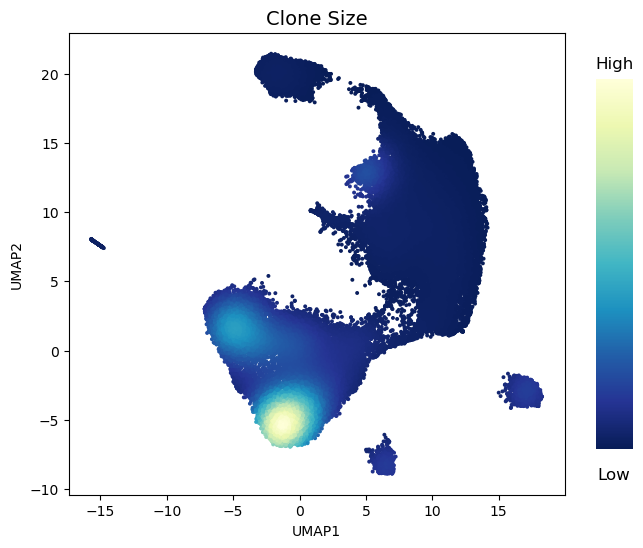

In [6]:
# Verificar si "clone_id_size" está en "airr" y no en "gex"
from scipy.stats import gaussian_kde
if "clone_id_size" in mdata["airr"].obs.columns and "clone_id_size" not in mdata["gex"].obs.columns:
    # Obtener las células comunes entre "gex" y "airr"
    common_cells = mdata["airr"].obs_names.intersection(mdata["gex"].obs_names)

    # Copiar "clone_id_size" a "gex"
    mdata["gex"].obs.loc[common_cells, "clone_id_size"] = mdata["airr"].obs.loc[common_cells, "clone_id_size"]
    print("✅ 'clone_id_size' copiado correctamente a 'gex'.")

# Ahora intenta acceder a la variable
umap_coords = mdata["gex"].obsm["X_umap"]
clone_sizes = mdata["gex"].obs["clone_id_size"].fillna(0).astype(float)  # Asegurar que es numérico

# Configuración del gráfico
plt.figure(figsize=(8, 6))

# Calcular densidad para suavizar los puntos
xy = np.vstack([umap_coords[:, 0], umap_coords[:, 1]])
z = gaussian_kde(xy, weights=clone_sizes)(xy)

# Crear scatter plot con el gradiente de color
scatter = plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=z, cmap='YlGnBu_r', s=8, edgecolor='none')

# Personalizar la barra de color sin borde y sin números
cbar = plt.colorbar(scatter, shrink=0.8, aspect=10)
cbar.set_ticks([])
cbar.outline.set_visible(False)

# Añadir etiquetas 'High' y 'Low' en la barra de color
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

# Títulos y etiquetas
plt.title('Clone Size', fontsize=14)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Eliminar el marco alrededor de la barra de color
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

plt.show()

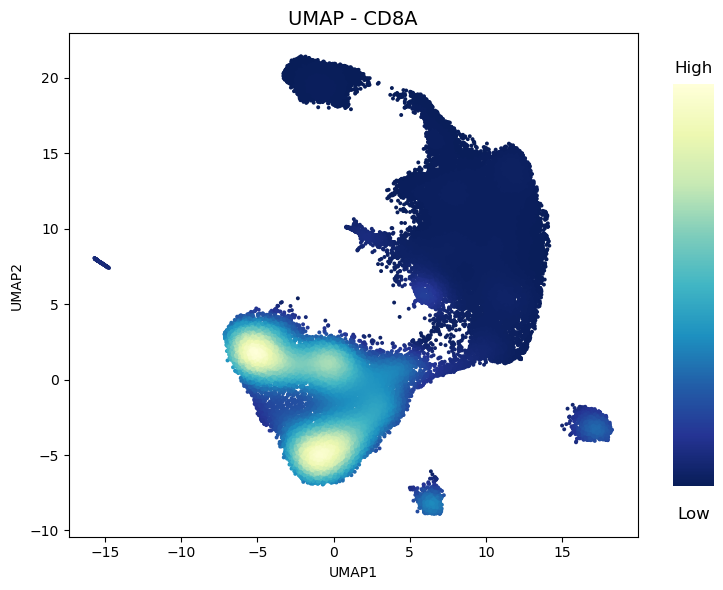

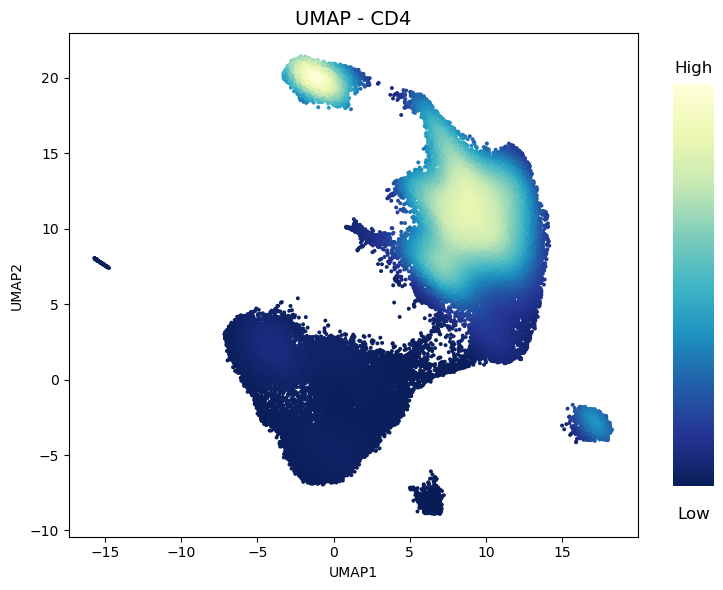

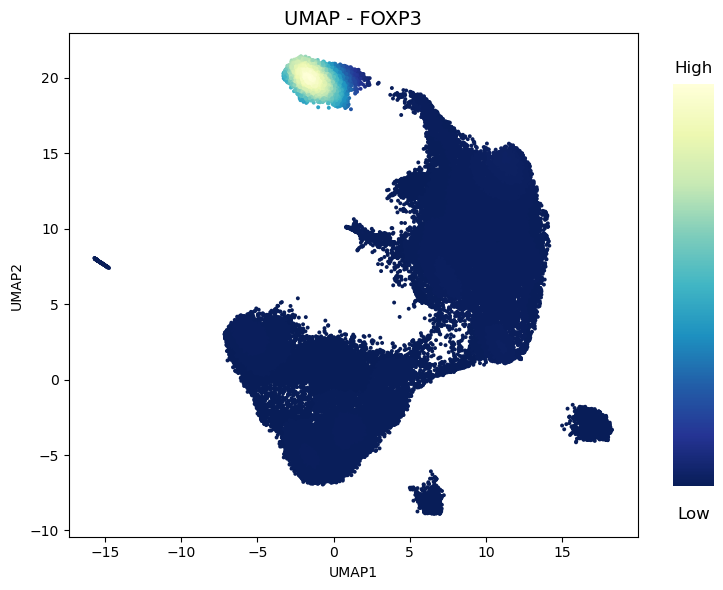

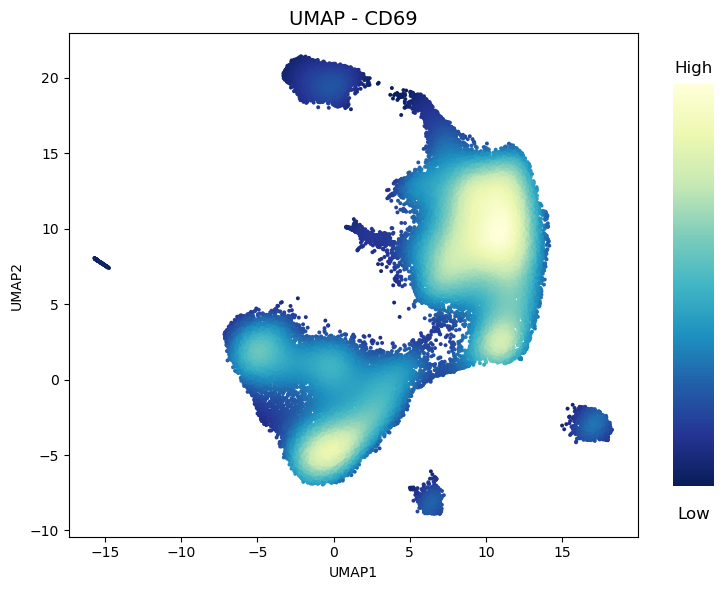

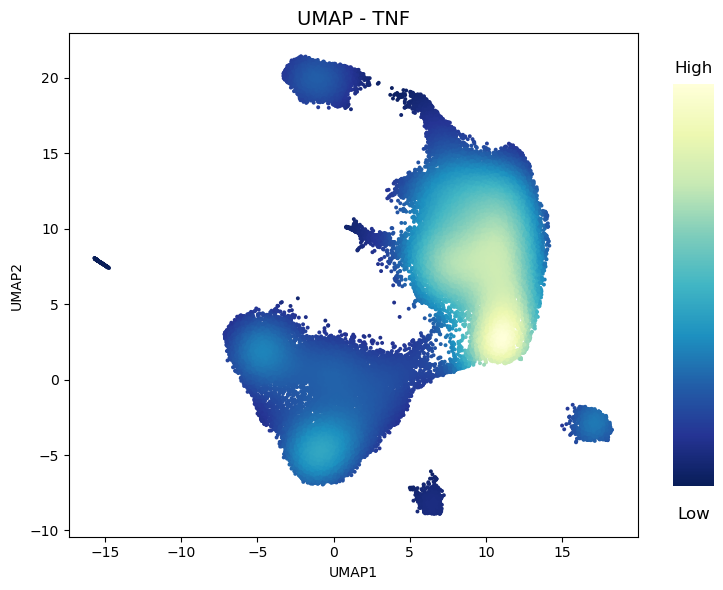

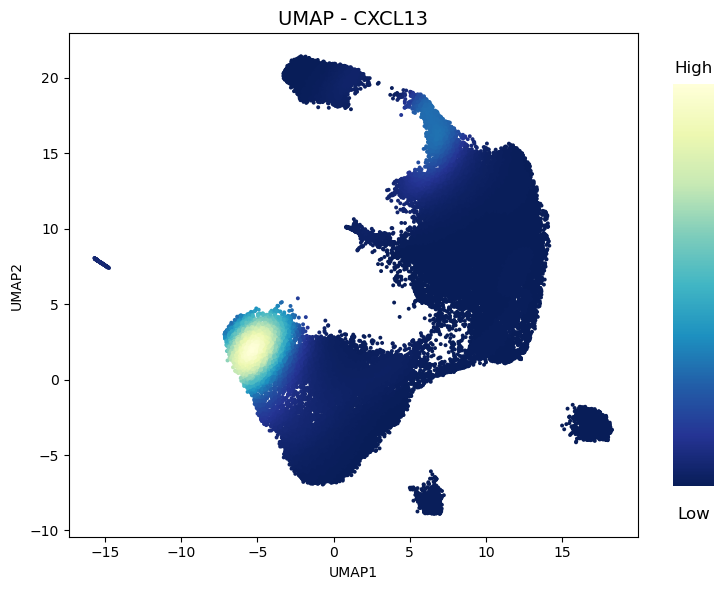

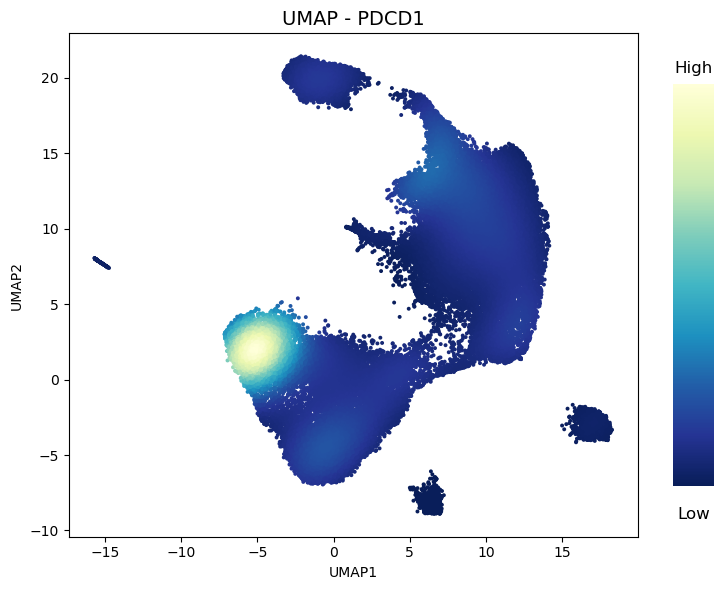

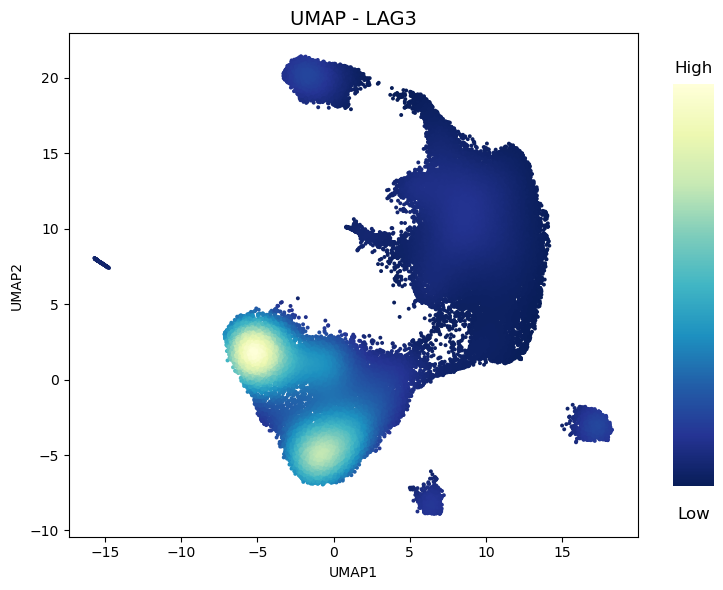

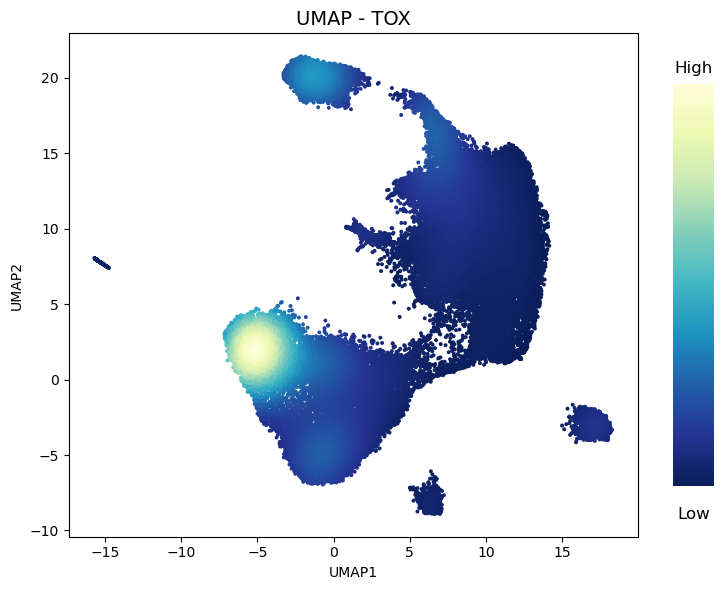

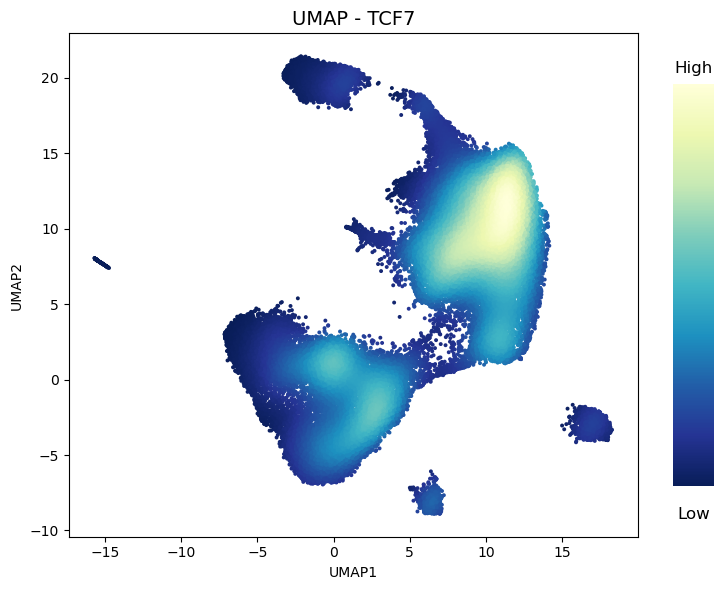

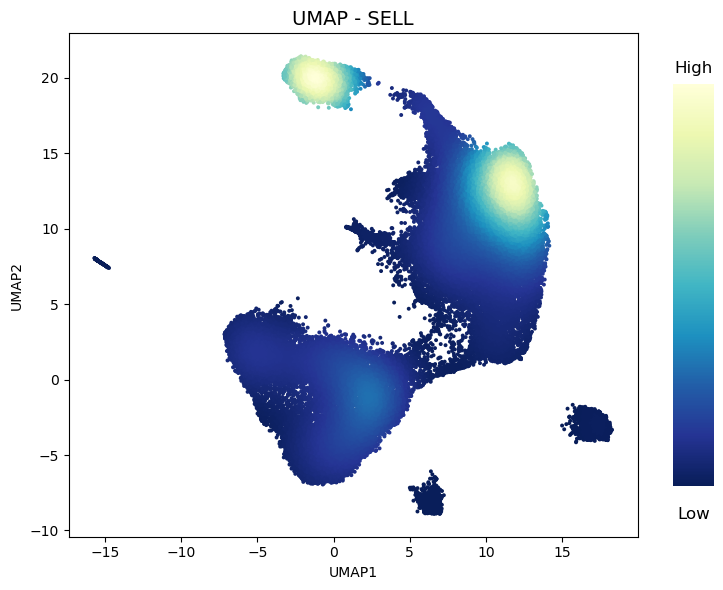

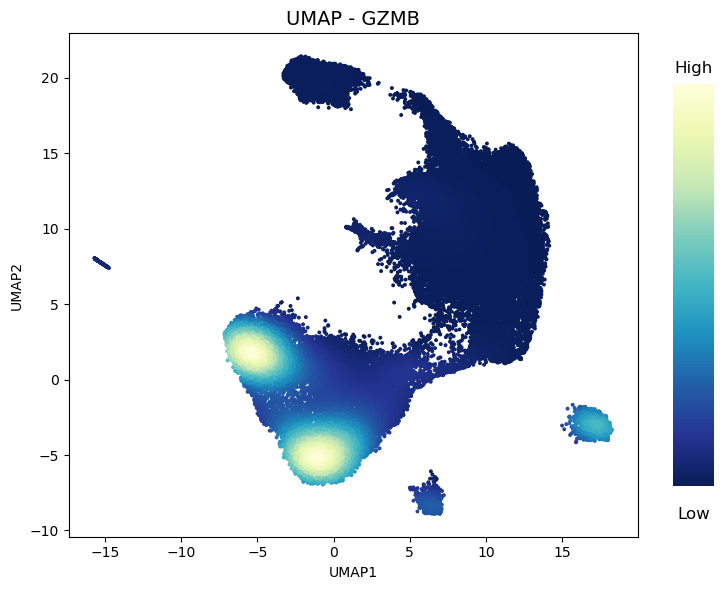

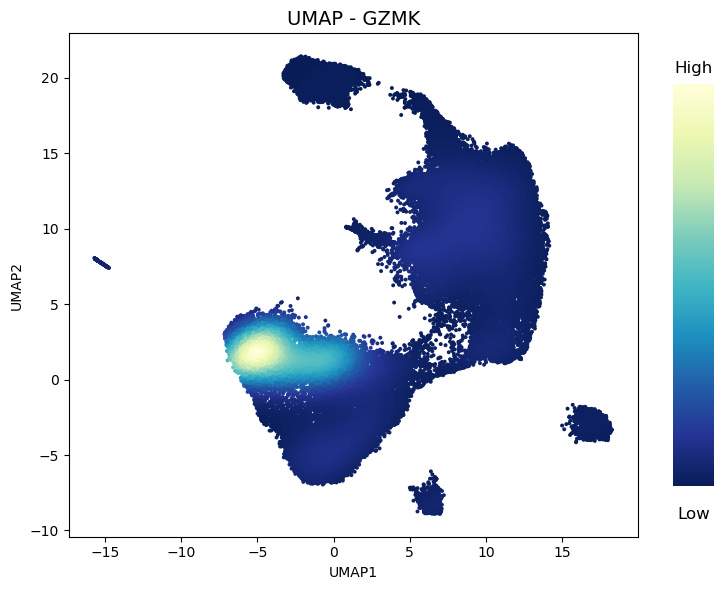

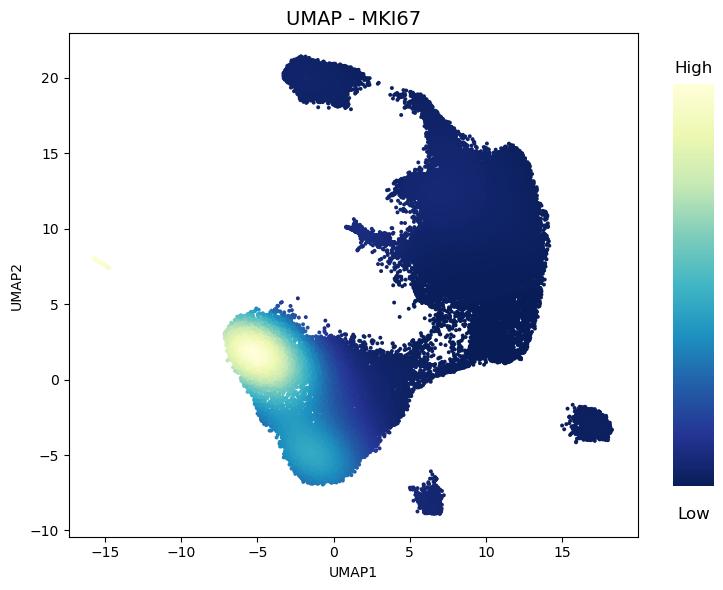

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Lista de genes a analizar
genes = ['CD8A', 'CD4', 'FOXP3', 'CD69', 'TNF', 'CXCL13', 'PDCD1', 'LAG3', 'TOX', 'TCF7', 'SELL', 'GZMB', 'GZMK', 'MKI67']

# Obtener las coordenadas UMAP
umap_coords = mdata.mod['gex'].obsm['X_umap']

# Recorrer cada gen y representarlo en un UMAP independiente
for gene in genes:
    # Verificar que el gen esté en var_names
    if gene in mdata.mod['gex'].var_names:
        # Obtener los valores de expresión del gen
        gene_expr = mdata.mod['gex'][:, gene].X.toarray().flatten()  # Expresión génica
    else:
        print(f"El gen {gene} no se encuentra en los datos.")
        continue

    # Calcular la densidad de puntos
    xy = np.vstack([umap_coords[:, 0], umap_coords[:, 1]])
    z = gaussian_kde(xy, weights=gene_expr)(xy)

    # Crear una nueva figura para cada gen
    fig, ax = plt.subplots(figsize=(8, 6))

    # Crear scatter plot para el gen
    scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=z, cmap='YlGnBu_r', s=8, edgecolor='none')
    ax.set_title(f'UMAP - {gene}', fontsize=14)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

    # Agregar la barra de color
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=10)
    cbar.set_ticks([])  # Quitar los números
    cbar.outline.set_visible(False)  # Eliminar el borde de la barra de color
    cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
    cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

    # Ajustar la visualización
    plt.tight_layout()

    # Mostrar la imagen de cada gen por separado
    plt.show()
    plt.pause(0.5)  # Pausa para asegurar que se renderiza bien antes de pasar al siguiente


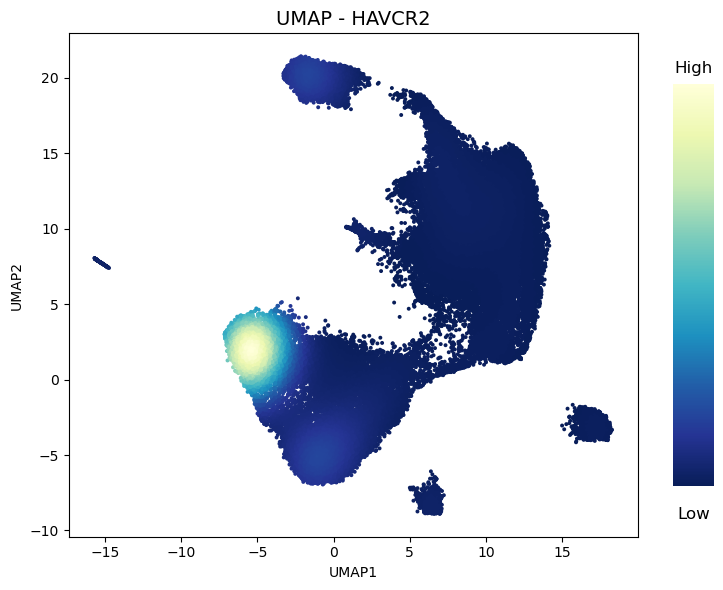

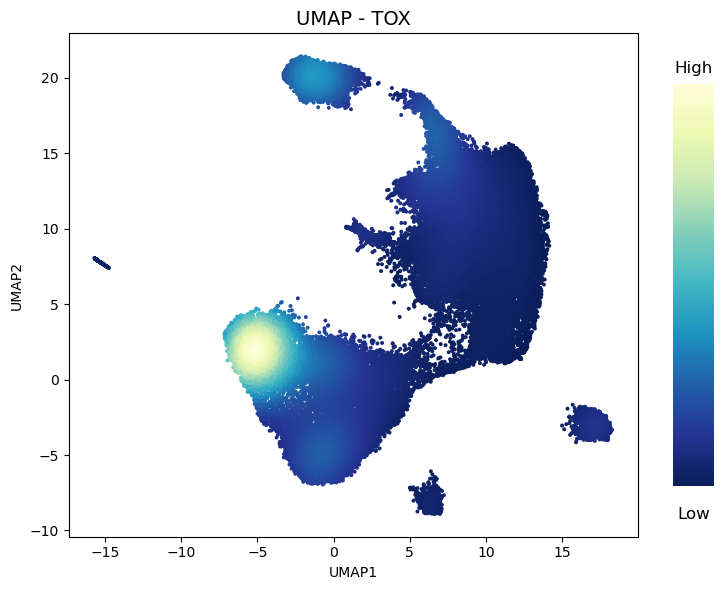

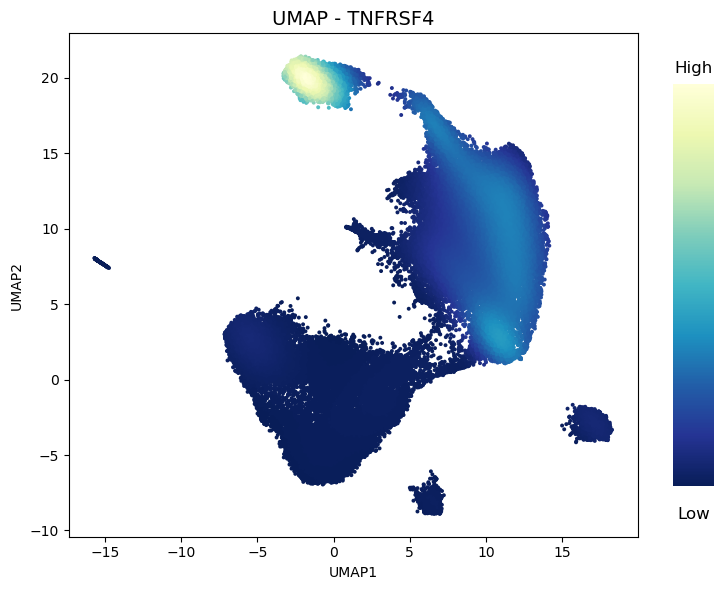

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Lista de genes a analizar
genes = ['HAVCR2','TOX','TNFRSF4']

# Obtener las coordenadas UMAP
umap_coords = mdata.mod['gex'].obsm['X_umap']

# Recorrer cada gen y representarlo en un UMAP independiente
for gene in genes:
    # Verificar que el gen esté en var_names
    if gene in mdata.mod['gex'].var_names:
        # Obtener los valores de expresión del gen
        gene_expr = mdata.mod['gex'][:, gene].X.toarray().flatten()  # Expresión génica
    else:
        print(f"El gen {gene} no se encuentra en los datos.")
        continue

    # Calcular la densidad de puntos
    xy = np.vstack([umap_coords[:, 0], umap_coords[:, 1]])
    z = gaussian_kde(xy, weights=gene_expr)(xy)

    # Crear una nueva figura para cada gen
    fig, ax = plt.subplots(figsize=(8, 6))

    # Crear scatter plot para el gen
    scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=z, cmap='YlGnBu_r', s=8, edgecolor='none')
    ax.set_title(f'UMAP - {gene}', fontsize=14)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

    # Agregar la barra de color
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=10)
    cbar.set_ticks([])  # Quitar los números
    cbar.outline.set_visible(False)  # Eliminar el borde de la barra de color
    cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
    cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

    # Ajustar la visualización
    plt.tight_layout()

    # Mostrar la imagen de cada gen por separado
    plt.show()
    plt.pause(0.5)  # Pausa para asegurar que se renderiza bien antes de pasar al siguiente

In [10]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL_KNN', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'clone_id_size'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p', 'neighbors'
      obsm:	'X_pca_harmony', 'X_umap'
      layers:	'counts_soupx_crude', 'original_counts'
      obsp:	'connectivities', 'distances'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq', 'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ', 'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ', 'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score', 'ATLAS_TIL_KNN', 'Celltypist', 'Celltypist_score', 'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

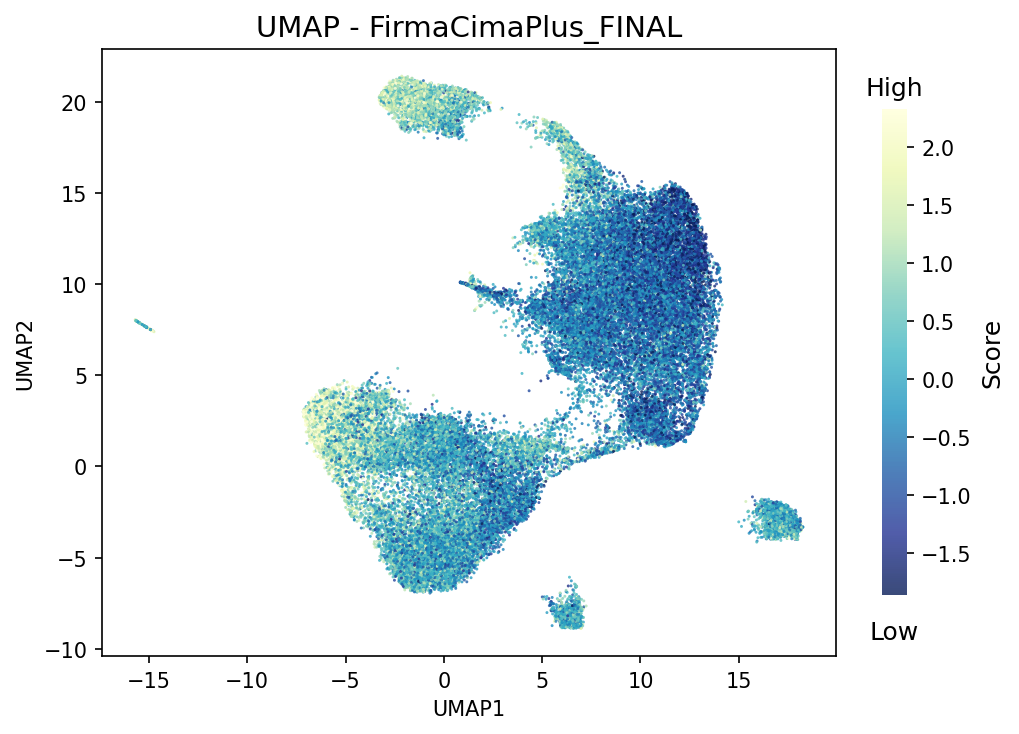

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener las coordenadas UMAP
umap_coords = mdata.mod['gex'].obsm['X_umap']
firma_values = mdata.mod['airr'].obs['FirmaCimaPlus_FINAL '].values

# Ajustar el rango para mejorar el contraste sin perder suavidad
vmin = np.percentile(firma_values, 2)
vmax = np.percentile(firma_values, 98)

# Crear la figura
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

# Scatter plot con colores más intensos
scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                     c=firma_values, cmap='YlGnBu_r', s=2, alpha=0.8,
                     edgecolor='none', vmin=vmin, vmax=vmax)

# Configuración del gráfico
ax.set_title('UMAP - FirmaCimaPlus_FINAL', fontsize=14)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# Barra de color
cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('Score', fontsize=12)
cbar.outline.set_visible(False)
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

plt.tight_layout()
plt.show()





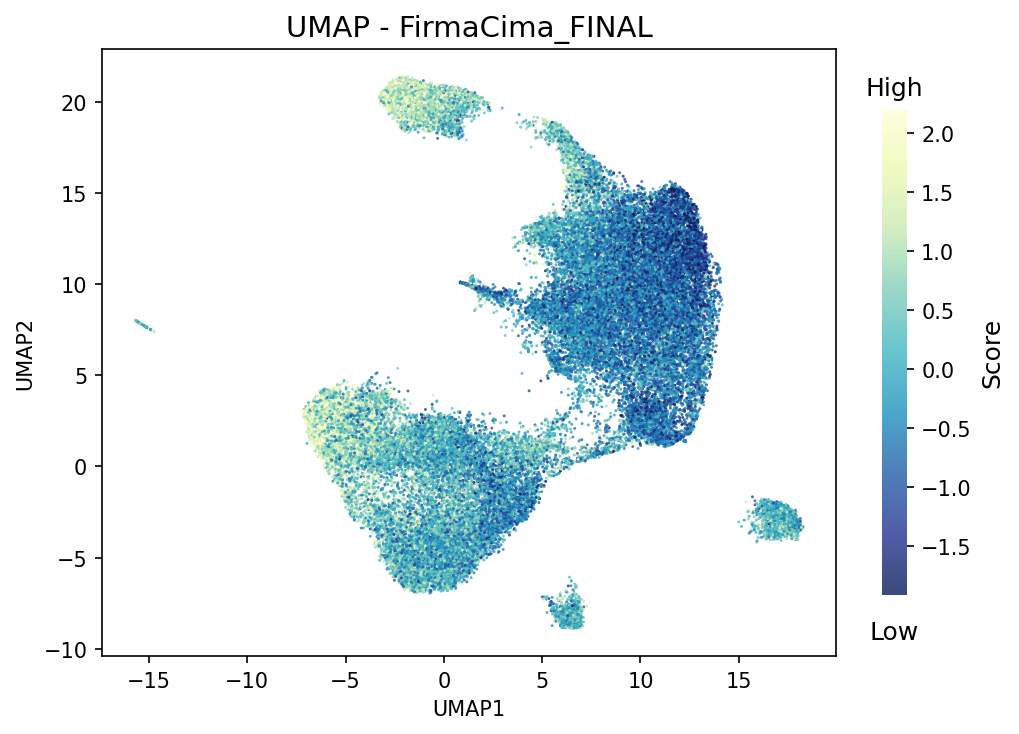

In [12]:
firma_values = mdata.mod['airr'].obs['FirmaCima_FINAL '].values

vmin = np.percentile(firma_values, 2)
vmax = np.percentile(firma_values, 98)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                     c=firma_values, cmap='YlGnBu_r', s=2, alpha=0.8,
                     edgecolor='none', vmin=vmin, vmax=vmax)

ax.set_title('UMAP - FirmaCima_FINAL', fontsize=14)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('Score', fontsize=12)
cbar.outline.set_visible(False)
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

plt.tight_layout()
plt.show()


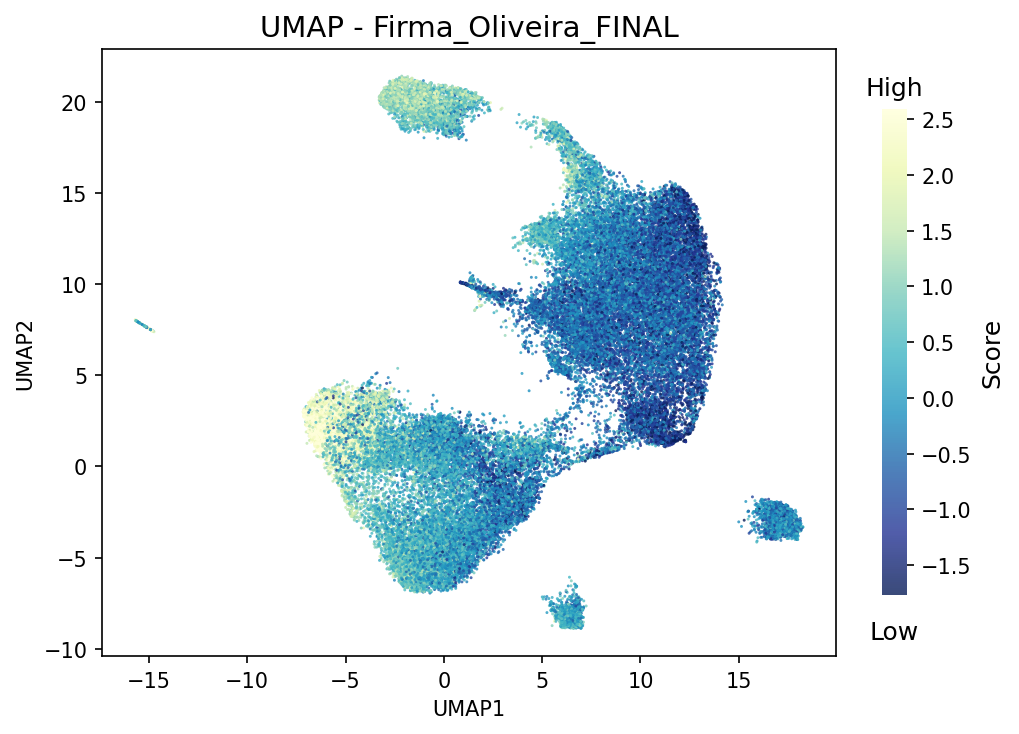

In [13]:
firma_values = mdata.mod['airr'].obs['Firma_Oliveira_FINAL '].values

vmin = np.percentile(firma_values, 2)
vmax = np.percentile(firma_values, 98)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                     c=firma_values, cmap='YlGnBu_r', s=2, alpha=0.8,
                     edgecolor='none', vmin=vmin, vmax=vmax)

ax.set_title('UMAP - Firma_Oliveira_FINAL', fontsize=14)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('Score', fontsize=12)
cbar.outline.set_visible(False)
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

plt.tight_layout()
plt.show()


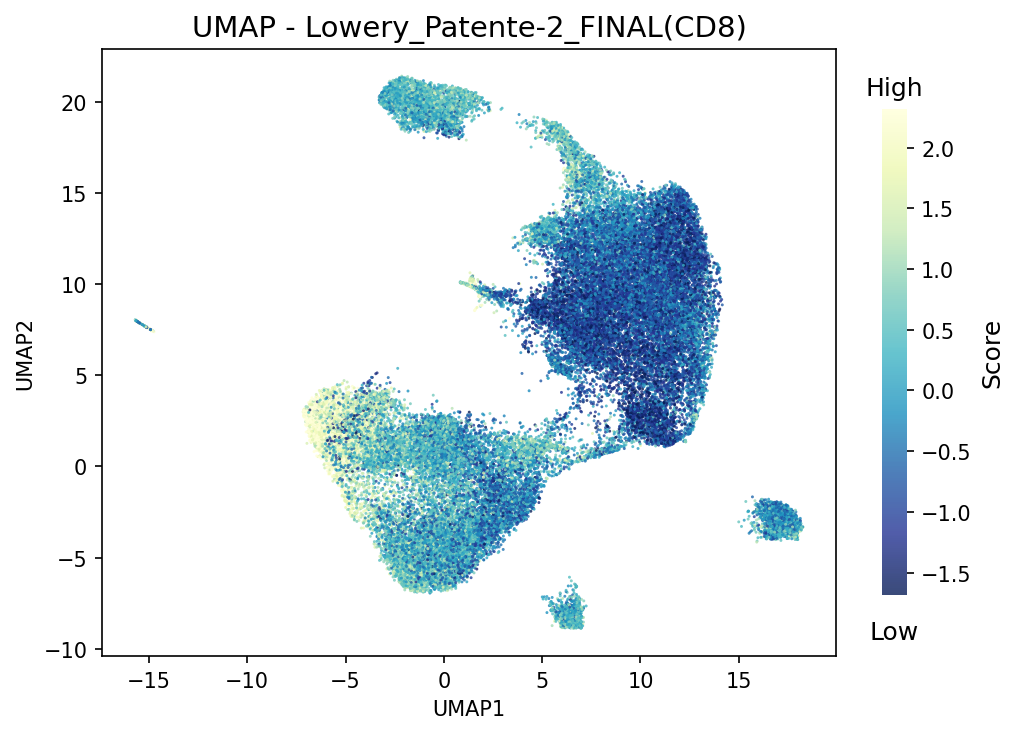

In [14]:
firma_values = mdata.mod['airr'].obs['Lowery_Patente-2_FINAL(CD8) '].values

vmin = np.percentile(firma_values, 2)
vmax = np.percentile(firma_values, 98)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                     c=firma_values, cmap='YlGnBu_r', s=2, alpha=0.8,
                     edgecolor='none', vmin=vmin, vmax=vmax)

ax.set_title('UMAP - Lowery_Patente-2_FINAL(CD8)', fontsize=14)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('Score', fontsize=12)
cbar.outline.set_visible(False)
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

plt.tight_layout()
plt.show()


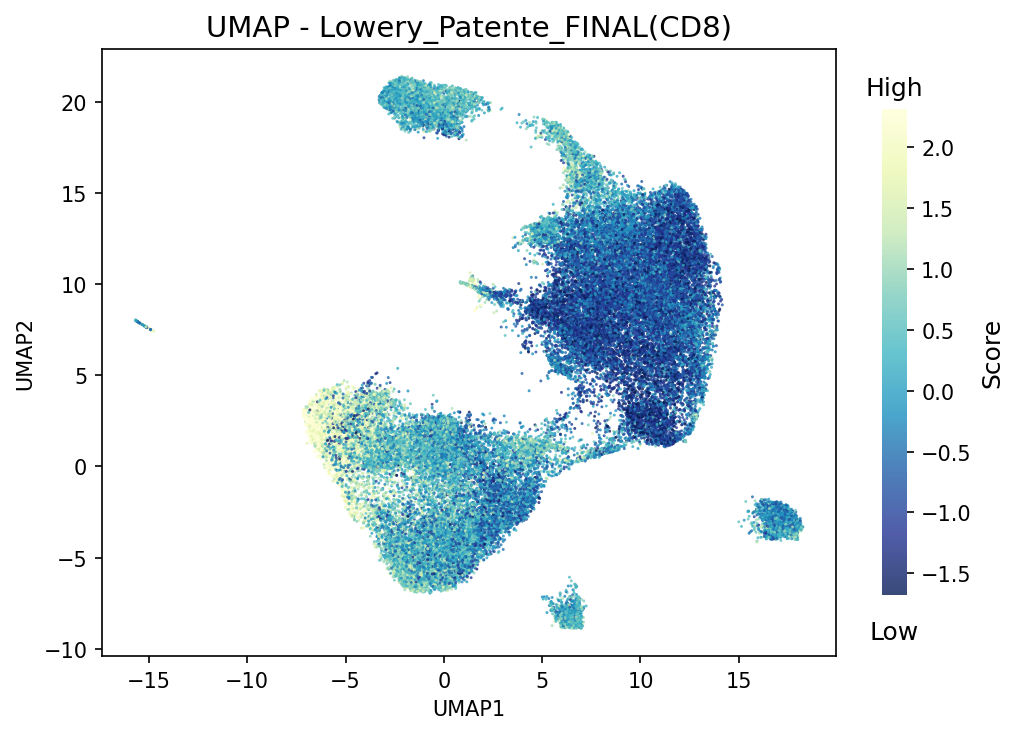

In [15]:
firma_values = mdata.mod['airr'].obs['Lowery_Patente_FINAL(CD8) '].values

vmin = np.percentile(firma_values, 2)
vmax = np.percentile(firma_values, 98)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                     c=firma_values, cmap='YlGnBu_r', s=2, alpha=0.8,
                     edgecolor='none', vmin=vmin, vmax=vmax)

ax.set_title('UMAP - Lowery_Patente_FINAL(CD8)', fontsize=14)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('Score', fontsize=12)
cbar.outline.set_visible(False)
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

plt.tight_layout()
plt.show()


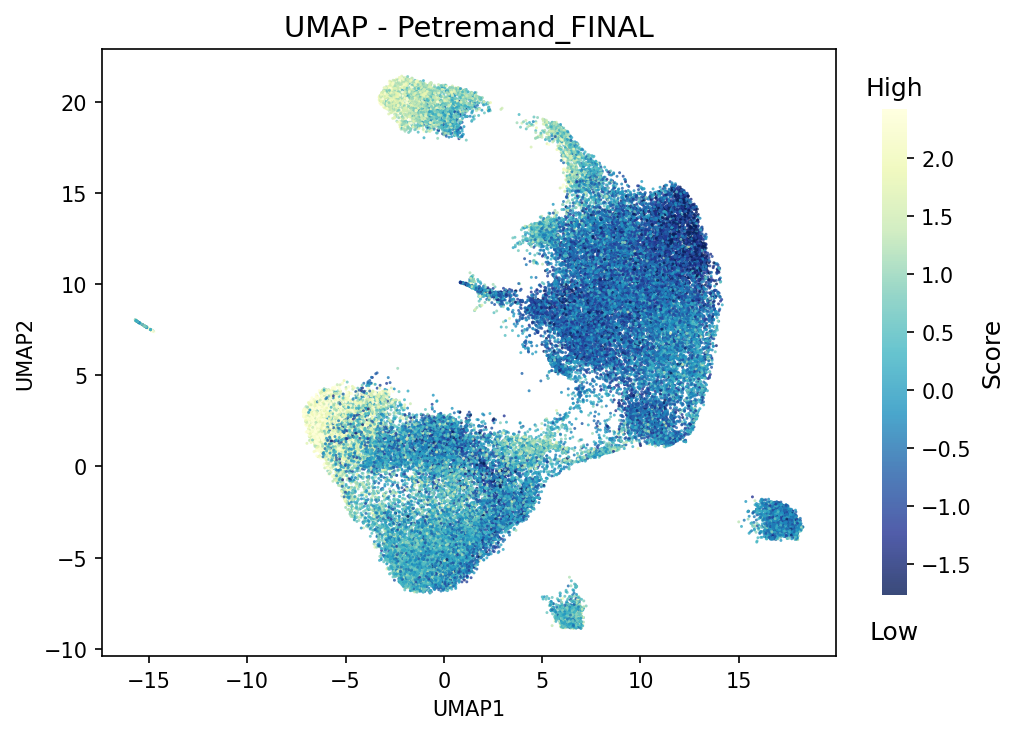

In [16]:
firma_values = mdata.mod['airr'].obs['Petremand_FINAL '].values

vmin = np.percentile(firma_values, 2)
vmax = np.percentile(firma_values, 98)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                     c=firma_values, cmap='YlGnBu_r', s=2, alpha=0.8,
                     edgecolor='none', vmin=vmin, vmax=vmax)

ax.set_title('UMAP - Petremand_FINAL', fontsize=14)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('Score', fontsize=12)
cbar.outline.set_visible(False)
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

plt.tight_layout()
plt.show()



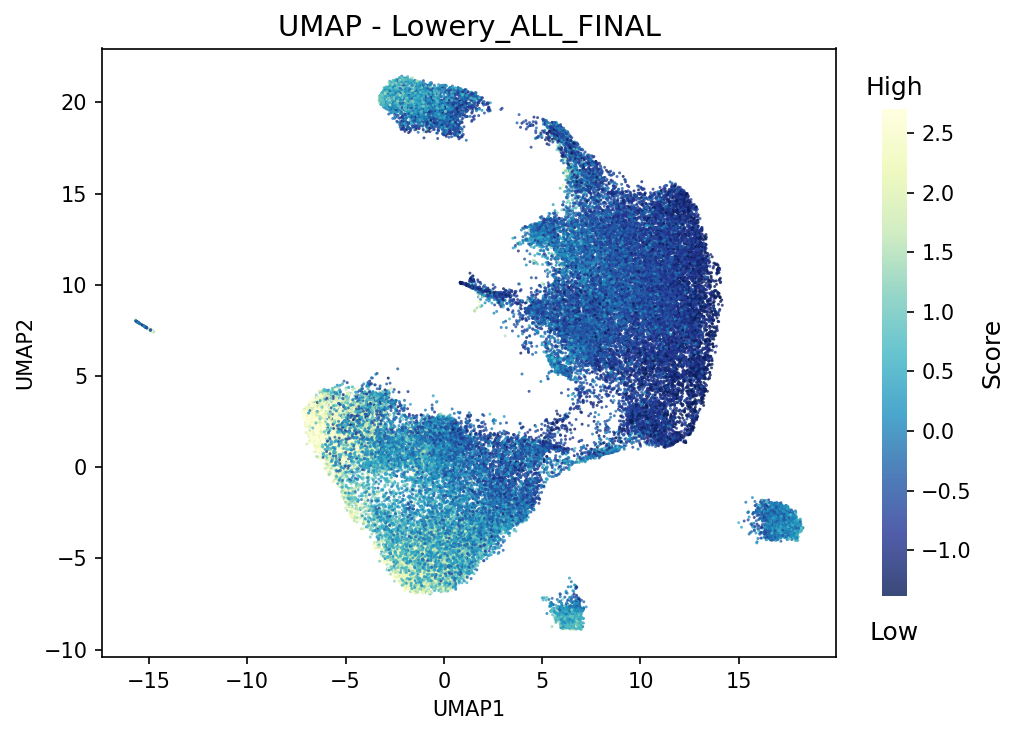

In [17]:
firma_values = mdata.mod['airr'].obs['Lowery_ALL_FINAL'].values

vmin = np.percentile(firma_values, 2)
vmax = np.percentile(firma_values, 98)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                     c=firma_values, cmap='YlGnBu_r', s=2, alpha=0.8,
                     edgecolor='none', vmin=vmin, vmax=vmax)

ax.set_title('UMAP - Lowery_ALL_FINAL', fontsize=14)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('Score', fontsize=12)
cbar.outline.set_visible(False)
cbar.ax.text(0.5, 1.02, 'High', ha='center', va='bottom', fontsize=12, transform=cbar.ax.transAxes)
cbar.ax.text(0.5, -0.05, 'Low', ha='center', va='top', fontsize=12, transform=cbar.ax.transAxes)

plt.tight_layout()
plt.show()



Montamos el excel arreglado:

In [ ]:
# Cargar el archivo MuData actualizado
mdata = mu.read("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/mudata_harmony_conTCR_KNN_leiden.h5mu")

In [ ]:
# Copiar las columnas 'leiden' y 'leiden_names' de la modalidad 'gex'
leiden_columns = mdata.mod["gex"].obs[["leiden", "leiden_names"]]

# Verificar que los índices coincidan entre gex.obs y airr.obs
if all(leiden_columns.index == mdata.mod["airr"].obs.index):
    # Asignar las columnas a airr
    mdata.mod["airr"].obs[["leiden", "leiden_names"]] = leiden_columns
else:
    # Si los índices no coinciden, mostramos un error
    print("Los índices no coinciden entre las modalidades 'gex' y 'airr'. No se pudo proceder.")

In [19]:
mdata.mod["airr"].obsm["airr"]

<Array [[{age: None, ...}, {...}], ..., [...]] type='49043 * var * {age: ?u...'>

In [20]:
# Aseguramos que tenemos los datos correctos
airr_df = ir.get.airr(mdata, airr_variable=["sequence_alignment","v_call", "d_call", "j_call", "c_call", 
                                            "fwr1", "fwr2", "fwr3", "fwr4", 
                                            "cdr1", "cdr2", "cdr3", 
                                            "junction", "junction_aa", "consensus_count"])

In [21]:
# Mostrar los nombres de las columnas
print(airr_df.columns)

Index(['VJ_1_sequence_alignment', 'VJ_1_v_call', 'VJ_1_d_call', 'VJ_1_j_call',
       'VJ_1_c_call', 'VJ_1_fwr1', 'VJ_1_fwr2', 'VJ_1_fwr3', 'VJ_1_fwr4',
       'VJ_1_cdr1', 'VJ_1_cdr2', 'VJ_1_cdr3', 'VJ_1_junction',
       'VJ_1_junction_aa', 'VJ_1_consensus_count', 'VDJ_1_sequence_alignment',
       'VDJ_1_v_call', 'VDJ_1_d_call', 'VDJ_1_j_call', 'VDJ_1_c_call',
       'VDJ_1_fwr1', 'VDJ_1_fwr2', 'VDJ_1_fwr3', 'VDJ_1_fwr4', 'VDJ_1_cdr1',
       'VDJ_1_cdr2', 'VDJ_1_cdr3', 'VDJ_1_junction', 'VDJ_1_junction_aa',
       'VDJ_1_consensus_count', 'VJ_2_sequence_alignment', 'VJ_2_v_call',
       'VJ_2_d_call', 'VJ_2_j_call', 'VJ_2_c_call', 'VJ_2_fwr1', 'VJ_2_fwr2',
       'VJ_2_fwr3', 'VJ_2_fwr4', 'VJ_2_cdr1', 'VJ_2_cdr2', 'VJ_2_cdr3',
       'VJ_2_junction', 'VJ_2_junction_aa', 'VJ_2_consensus_count',
       'VDJ_2_sequence_alignment', 'VDJ_2_v_call', 'VDJ_2_d_call',
       'VDJ_2_j_call', 'VDJ_2_c_call', 'VDJ_2_fwr1', 'VDJ_2_fwr2',
       'VDJ_2_fwr3', 'VDJ_2_fwr4', 'VDJ_2_cdr1', 'VDJ_2_c

In [22]:
# Cambiar los nombres de las columnas
airr_df.columns = airr_df.columns.str.replace("VJ_", "alfa_")
airr_df.columns = airr_df.columns.str.replace("VDJ_", "beta_")

In [23]:
airr_df

alfa_1_sequence_alignment  \
cell_id                                                                      
AAACCTGAGAAGAAGC-1_PT14  GCCCAGTCGGTGACCCAGCTTGGCAGCCACGTCTCTGTCTCTGAAG...   
AAACCTGAGGACAGAA-1_PT14  GGAGAGAGTGTGGGGCTGCATCTTCCTACCCTGAGTGTCCAGGAGG...   
AAACCTGAGTGGAGTC-1_PT14  GGAGATTCAGTGACCCAGATGGAAGGGCCAGTGACTCTCTCAGAAG...   
AAACCTGAGTGTCTCA-1_PT14  AGTCAACAGGGAGAAGAGGATCCTCAGGCCTTGAGCATCCAGGAGG...   
AAACCTGCAAACTGTC-1_PT14  CAGAAGGAGGTGGAGCAGGATCCTGGACCACTCAGTGTTCCAGAGG...   
...                                                                    ...   
TTTGTCAGTGTGGCTC-1_PT50  CAGAAGGAGGTGGAGCAGGATCCTGGACCACTCAGTGTTCCAGAGG...   
TTTGTCATCGTGGGAA-1_PT50  CAACAACCAGTG...CAGAGTCCTCAAGCCGTGATCCTCCGAGAAG...   
TTTGTCATCTGCTGCT-1_PT50  GGAGATTCAGTGACCCAGATGGAAGGGCCAGTGACTCTCTCAGAAG...   
TTTGTCATCTTGTTTG-1_PT50  GCCCAGAAGATAACTCAAACCCAACCAGGAATGTTCGTGCAGGAAA...   
TTTGTCATCTTTAGTC-1_PT50  GCTCAGAAGGTAACTCAAGCGCAGACTGAAATTTCTGTGGTGGAGA...   

                         alfa_1_v_call alfa_1_d_call alfa_1_j_call  \
cell_id                                                              
AAACCTGAGAAGAAGC-1_PT14     TRAV8-4*01          None      TRAJ8*01   
AAACCTGAGGACAGAA-1_PT14    TRAV13-2*01          None      TRAJ9*01   
AAACCTGAGTGGAGTC-1_PT14     TRAV9-2*02          None     TRAJ17*01   
AAACCTGAGTGTCTCA-1_PT14      TRAV17*01          None     TRAJ20*01   
AAACCTGCAAACTGTC-1_PT14    TRAV12-3*01          None     TRAJ52*01   
...                                ...           ...           ...   
TTTGTCAGTGTGGCTC-1_PT50    TRAV12-3*01          None      TRAJ8*01   
TTTGTCATCGTGGGAA-1_PT50      TRAV30*01          None     TRAJ13*02   
TTTGTCATCTGCTGCT-1_PT50     TRAV9-2*02          None     TRAJ22*01   
TTTGTCATCTTGTTTG-1_PT50  TRAV14/DV4*02          None     TRAJ28*01   
TTTGTCATCTTTAGTC-1_PT50      TRAV19*01          None     TRAJ37*02   

                        alfa_1_c_call  \
cell_id                                 
AAACCTGAGAAGAAGC-1_PT14       TRAC*01   
AAACCTGAGGACAGAA-1_PT14       TRAC*01   
AAACCTGAGTGGAGTC-1_PT14       TRAC*01   
AAACCTGAGTGTCTCA-1_PT14       TRAC*01   
AAACCTGCAAACTGTC-1_PT14       TRAC*01   
...                               ...   
TTTGTCAGTGTGGCTC-1_PT50       TRAC*01   
TTTGTCATCGTGGGAA-1_PT50       TRAC*01   
TTTGTCATCTGCTGCT-1_PT50       TRAC*01   
TTTGTCATCTTGTTTG-1_PT50       TRAC*01   
TTTGTCATCTTTAGTC-1_PT50       TRAC*01   

                                                               alfa_1_fwr1  \
cell_id                                                                      
AAACCTGAGAAGAAGC-1_PT14  GCCCAGTCGGTGACCCAGCTTGGCAGCCACGTCTCTGTCTCTGAAG...   
AAACCTGAGGACAGAA-1_PT14  GGAGAGAGTGTGGGGCTGCATCTTCCTACCCTGAGTGTCCAGGAGG...   
AAACCTGAGTGGAGTC-1_PT14  GGAGATTCAGTGACCCAGATGGAAGGGCCAGTGACTCTCTCAGAAG...   
AAACCTGAGTGTCTCA-1_PT14  AGTCAACAGGGAGAAGAGGATCCTCAGGCCTTGAGCATCCAGGAGG...   
AAACCTGCAAACTGTC-1_PT14  CAGAAGGAGGTGGAGCAGGATCCTGGACCACTCAGTGTTCCAGAGG...   
...                                                                    ...   
TTTGTCAGTGTGGCTC-1_PT50  CAGAAGGAGGTGGAGCAGGATCCTGGACCACTCAGTGTTCCAGAGG...   
TTTGTCATCGTGGGAA-1_PT50  CAACAACCAGTG...CAGAGTCCTCAAGCCGTGATCCTCCGAGAAG...   
TTTGTCATCTGCTGCT-1_PT50  GGAGATTCAGTGACCCAGATGGAAGGGCCAGTGACTCTCTCAGAAG...   
TTTGTCATCTTGTTTG-1_PT50  GCCCAGAAGATAACTCAAACCCAACCAGGAATGTTCGTGCAGGAAA...   
TTTGTCATCTTTAGTC-1_PT50  GCTCAGAAGGTAACTCAAGCGCAGACTGAAATTTCTGTGGTGGAGA...   

                                                               alfa_1_fwr2  \
cell_id                                                                      
AAACCTGAGAAGAAGC-1_PT14  CTCTTCTGGTATGTGCAATACCCCAACCAAGGACTCCAGCTTCTCC...   
AAACCTGAGGACAGAA-1_PT14  TTCATTTGGTACAAGCAAGAATCTGGAAAAGGTCCTCAATTCATTA...   
AAACCTGAGTGGAGTC-1_PT14  CTTTTCTGGTATGTCCAATATCCTGGAGAAGGTCTACAGCTCCTCC...   
AAACCTGAGTGTCTCA-1_PT14  TTACAGTGGTATAGACAAAATTCAGGTAGAGGCCTTGTCCACCTAA...   
AAACCTGCAAACTGTC-1_PT14  TTCATGTGGTACAGACAGTATTCCAGAAAAGGCCCTGAGTTGCTGA...   
...                         

In [24]:
# Crear un DataFrame con los datos de 'obs' (metadatos) de mdata
obs_data = mdata.mod["airr"].obs

In [25]:
obs_data

sample receptor_type receptor_subtype chain_pairing  \
cell_id                                                                       
AAACCTGAGAAGAAGC-1_PT14  PT_14           TCR          TRA+TRB   single pair   
AAACCTGAGGACAGAA-1_PT14  PT_14           TCR          TRA+TRB   single pair   
AAACCTGAGTGGAGTC-1_PT14  PT_14           TCR          TRA+TRB   single pair   
AAACCTGAGTGTCTCA-1_PT14  PT_14           TCR          TRA+TRB   single pair   
AAACCTGCAAACTGTC-1_PT14  PT_14           TCR          TRA+TRB      extra VJ   
...                        ...           ...              ...           ...   
TTTGTCAGTGTGGCTC-1_PT50  PT_50           TCR          TRA+TRB   single pair   
TTTGTCATCGTGGGAA-1_PT50  PT_50           TCR          TRA+TRB   single pair   
TTTGTCATCTGCTGCT-1_PT50  PT_50           TCR          TRA+TRB   single pair   
TTTGTCATCTTGTTTG-1_PT50  PT_50           TCR          TRA+TRB   single pair   
TTTGTCATCTTTAGTC-1_PT50  PT_50           TCR          TRA+TRB   single pair   

                        clone_id  clone_id_size clonal_expansion  \
cell_id                                                            
AAACCTGAGAAGAAGC-1_PT14        0             32             ≤ 50   
AAACCTGAGGACAGAA-1_PT14        1              1              ≤ 1   
AAACCTGAGTGGAGTC-1_PT14        2              1              ≤ 1   
AAACCTGAGTGTCTCA-1_PT14        3              1              ≤ 1   
AAACCTGCAAACTGTC-1_PT14        4              1              ≤ 1   
...                          ...            ...              ...   
TTTGTCAGTGTGGCTC-1_PT50    19839             70            ≤ 100   
TTTGTCATCGTGGGAA-1_PT50    19835            241            ≤ 500   
TTTGTCATCTGCTGCT-1_PT50    20128             16             ≤ 50   
TTTGTCATCTTGTTTG-1_PT50    19804            421            ≤ 500   
TTTGTCATCTTTAGTC-1_PT50    21046              3             ≤ 10   

                         clone_id_freq  FirmaCimaPlus_FINAL   \
cell_id                                                        
AAACCTGAGAAGAAGC-1_PT14       0.000424             -0.752329   
AAACCTGAGGACAGAA-1_PT14       0.000013              0.625701   
AAACCTGAGTGGAGTC-1_PT14       0.000013              2.025910   
AAACCTGAGTGTCTCA-1_PT14       0.000013              0.921286   
AAACCTGCAAACTGTC-1_PT14       0.000013             -0.629738   
...                                ...                   ...   
TTTGTCAGTGTGGCTC-1_PT50       0.000237              0.741716   
TTTGTCATCGTGGGAA-1_PT50       0.000817             -0.220452   
TTTGTCATCTGCTGCT-1_PT50       0.000054              0.737083   
TTTGTCATCTTGTTTG-1_PT50       0.001427             -0.660960   
TTTGTCATCTTTAGTC-1_PT50       0.000010             -0.483181   

                         FirmaCima_FINAL   ...  Petremand_FINAL   \
cell_id                                    ...                     
AAACCTGAGAAGAAGC-1_PT14         -0.758073  ...         -1.188962   
AAACCTGAGGACAGAA-1_PT14          0.118228  ...          0.346079   
AAACCTGAGTGGAGTC-1_PT14          2.215051  ...          1.278230   
AAACCTGAGTGTCTCA-1_PT14          0.943197  ...         -0.106789   
AAACCTGCAAACTGTC-1_PT14         -0.644773  ...         -0.889228   
...                                   ...  ...               ...   
TTTGTCAGTGTGGCTC-1_PT50          0.944403  ...          1.873980   
TTTGTCATCGTGGGAA-1_PT50         -0.178621  ...         -0.014812   
TTTGTCATCTGCTGCT-1_PT50          0.898829  ...          1.224015   
TTTGTCATCTTGTTTG-1_PT50         -0.739454  ...          0.107406   
TTTGTCATCTTTAGTC-1_PT50         -0.491419  ...         -0.841132   

                         Lowery_ALL_FINAL      ATLAS_TIL  ATLAS_TIL_score  \
cell_id                                                                     
AAACCTGAGAAGAAGC-1_PT14          0.828910         CD8.CM         1.000000   
AAACCTGAGGACAGAA-1_PT14          0.079219        CD4.Tfh         1.000000   
AAACCTGAGTGGAGTC-1_PT14          1.133224       CD4.Treg         1.000000   
AAACCTGA

In [26]:
# Asegúrate de que ambos índices sean strings y sin espacios en blanco
mdata.mod["airr"].obs.index = mdata.mod["airr"].obs.index.astype(str).str.strip()
airr_df.index = airr_df.index.astype(str).str.strip()

In [27]:
# Verifica si hay índices que no coinciden
unmatched_in_mdata = mdata.mod["airr"].obs.index.difference(airr_df.index)
unmatched_in_airr = airr_df.index.difference(mdata.mod["airr"].obs.index)

print(f"Índices no coincidentes en mdata: {len(unmatched_in_mdata)}")
print(f"Índices no coincidentes en airr_df: {len(unmatched_in_airr)}")

Índices no coincidentes en mdata: 0
Índices no coincidentes en airr_df: 0


In [28]:
# Asegurarnos de que ambos índices son de tipo string
mdata.mod["airr"].obs.index = mdata.mod["airr"].obs.index.astype(str)
airr_df.index = airr_df.index.astype(str)

In [29]:
# Verificar que ambos DataFrames tienen el mismo número de filas
if len(mdata.mod["airr"].obs) == len(airr_df):
    # Concatenar por posición usando NumPy
    combined_array = np.concatenate([mdata.mod["airr"].obs.values, airr_df.values], axis=1)

    # Crear un nuevo DataFrame combinando las columnas de ambos DataFrames
    combined_df = pd.DataFrame(combined_array, columns=list(mdata.mod["airr"].obs.columns) + list(airr_df.columns))

    # Asignar el índice original (cell_id)
    combined_df.index = mdata.mod["airr"].obs.index

    print("✅ Los DataFrames se han combinado correctamente.")
else:
    print("❌ Los DataFrames no tienen el mismo número de filas.")

✅ Los DataFrames se han combinado correctamente.


In [30]:
#TARDA UN PELIN
# Exportar el DataFrame tal cual está a Excel
file_path = '/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/combined_df_sin_orphanVJ_leiden.xlsx'

# Guardar en Excel sin alterar los formatos
combined_df.to_excel(file_path, index=True, engine='xlsxwriter')

print(f"✅ El archivo se ha guardado exactamente como '{file_path}'")

✅ El archivo se ha guardado exactamente como '/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/combined_df_sin_orphanVJ_leiden.xlsx'


### ARREGLAR EL EXCEL PARA QUE ESTE POR CLONOTIPOS: 

In [30]:
combined_df.columns

Index(['sample', 'receptor_type', 'receptor_subtype', 'chain_pairing',
       'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq',
       'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ',
       'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ',
       'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score',
       'ATLAS_TIL_KNN', 'Celltypist', 'Celltypist_score',
       'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z',
       'alfa_1_sequence_alignment', 'alfa_1_v_call', 'alfa_1_d_call',
       'alfa_1_j_call', 'alfa_1_c_call', 'alfa_1_fwr1', 'alfa_1_fwr2',
       'alfa_1_fwr3', 'alfa_1_fwr4', 'alfa_1_cdr1', 'alfa_1_cdr2',
       'alfa_1_cdr3', 'alfa_1_junction', 'alfa_1_junction_aa',
       'alfa_1_consensus_count', 'beta_1_sequence_alignment', 'beta_1_v_call',
       'beta_1_d_call', 'beta_1_j_call', 'beta_1_c_call', 'beta_1_fwr1',
       'beta_1_fwr2', 'beta_1_fwr3', 'beta_1_fwr4', 'beta_1_cdr1',
       'beta_1_cdr2', '

In [31]:
# Lista completa de columnas a eliminar
cols_to_drop = [
    'alfa_1_fwr1', 'alfa_1_fwr2', 'alfa_1_fwr3', 'alfa_1_fwr4',
    'alfa_1_sequence_alignment', 'beta_1_sequence_alignment', 'beta_1_fwr1',
    'beta_1_fwr2', 'beta_1_fwr3', 'beta_1_fwr4', 'beta_1_consensus_count',
    'alfa_2_sequence_alignment', 'alfa_2_v_call', 'alfa_2_d_call', 'alfa_2_j_call', 'alfa_2_c_call',
    'alfa_2_fwr1', 'alfa_2_fwr2', 'alfa_2_fwr3', 'alfa_2_fwr4',
    'alfa_2_cdr1', 'alfa_2_cdr2', 'alfa_2_cdr3', 'alfa_2_junction', 'alfa_2_junction_aa',
    'alfa_2_consensus_count', 'beta_2_sequence_alignment', 'beta_2_v_call',
    'beta_2_d_call', 'beta_2_j_call', 'beta_2_c_call', 'beta_2_fwr1',
    'beta_2_fwr2', 'beta_2_fwr3', 'beta_2_fwr4', 'beta_2_cdr1',
    'beta_2_cdr2', 'beta_2_cdr3', 'beta_2_junction', 'beta_2_junction_aa',
    'beta_2_consensus_count',
    'alfa_1_v_call', 'alfa_1_d_call', 'alfa_1_j_call', 'alfa_1_c_call', 
    'alfa_1_cdr1', 'alfa_1_cdr2', 'alfa_1_cdr3', 'alfa_1_junction', 'alfa_1_junction_aa',
    'alfa_1_consensus_count', 'beta_1_v_call', 'beta_1_d_call',
    'beta_1_j_call', 'beta_1_c_call', 'beta_1_cdr1', 'beta_1_cdr2',
    'beta_1_cdr3', 'beta_1_junction', 'beta_1_junction_aa'
]

# Eliminar las columnas si existen en el DataFrame
combined_df_clonotipos = combined_df.drop(columns=[col for col in cols_to_drop if col in combined_df.columns])

In [32]:
combined_df_clonotipos.columns

Index(['sample', 'receptor_type', 'receptor_subtype', 'chain_pairing',
       'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq',
       'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ',
       'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ',
       'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score',
       'ATLAS_TIL_KNN', 'Celltypist', 'Celltypist_score',
       'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z'],
      dtype='object')

In [33]:
# Ver si el clon_id aparece en diferentes pacientes
clone_sample_counts = combined_df_clonotipos.groupby(["clone_id"])["sample"].nunique()

# Filtrar clonotipos que aparecen en más de un sample (indicando que están en múltiples pacientes)
shared_across_patients = clone_sample_counts[clone_sample_counts > 1]

# Mostrar los clonotipos compartidos entre diferentes pacientes
print(f"✅ Se encontraron {len(shared_across_patients)} clonotipos compartidos entre diferentes pacientes.")
print(shared_across_patients)


✅ Se encontraron 1 clonotipos compartidos entre diferentes pacientes.
clone_id
15822    2
Name: sample, dtype: int64


In [34]:
# Lista de columnas a conservar de la primera fila por clon_id
cols_to_keep = [
    'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing',
    'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq',
    'ATLAS_TIL', 'ATLAS_TIL_score', 'ATLAS_TIL_KNN', 'Celltypist', 'Celltypist_score'
]

# Lista de columnas de firmas a las que se aplicarán estadísticas
cols_to_aggregate = [
    'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ',
    'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ',
    'Petremand_FINAL ', 'Lowery_ALL_FINAL'
]

# Definir funciones de agregación para las firmas
agg_funcs = {col: ['mean', 'median', 'std', 'max', 'min'] for col in cols_to_aggregate}

# Agrupar por clon_id
combined_df_clonotipos_aggregated = (
    combined_df_clonotipos
    .sort_values(by="clone_id")  # Ordenar por clon_id
    .groupby("clone_id", as_index=False)  # Agrupar por clon_id
    .agg({**{col: 'first' for col in cols_to_keep}, **agg_funcs})  # Aplicar agregaciones
)

# Aplanar las columnas después de la agregación múltiple
combined_df_clonotipos_aggregated.columns = [
    f"{col[0]}-{col[1]}" if col[1] else col[0] for col in combined_df_clonotipos_aggregated.columns
]

In [35]:
# Renombrar las columnas
new_columns = []
for col in combined_df_clonotipos_aggregated.columns:
    if col.endswith("-first"):  # Si la columna termina en "-first"
        new_columns.append(col.replace("-first", ""))  # Eliminar el sufijo "-first"
    else:
        new_columns.append(col)  # Mantener el nombre original

# Asignar los nuevos nombres de columnas al DataFrame
combined_df_clonotipos_aggregated.columns = new_columns

In [36]:
combined_df_clonotipos_aggregated.head()

sample receptor_type receptor_subtype chain_pairing clone_id clone_id_size  \
0  PT_14           TCR          TRA+TRB   single pair        0            32   
1  PT_14           TCR          TRA+TRB   single pair        1             1   
2  PT_14           TCR          TRA+TRB   single pair       10             3   
3  PT_14           TCR          TRA+TRB   single pair      100             2   
4  PT_14           TCR          TRA+TRB   single pair     1000             1   

  clonal_expansion clone_id_freq      ATLAS_TIL ATLAS_TIL_score  ...  \
0             ≤ 50      0.000424         CD8.CM             1.0  ...   
1              ≤ 1      0.000013        CD4.Tfh             1.0  ...   
2             ≤ 10       0.00004  CD4.NaiveLike         0.46013  ...   
3             ≤ 10      0.000026        CD4.Tfh        0.780264  ...   
4              ≤ 1      0.000013  CD4.NaiveLike             1.0  ...   

  Petremand_FINAL -mean Petremand_FINAL -median Petremand_FINAL -std  \
0             -0.238339               -0.262183             0.443094   
1              0.346079                0.346079                  NaN   
2             -0.813125               -1.011816             0.813151   
3               0.47617                 0.47617             0.262894   
4             -1.607599               -1.607599                  NaN   

  Petremand_FINAL -max Petremand_FINAL -min  Lowery_ALL_FINAL-mean  \
0             0.623192            -1.189155               0.053636   
1             0.346079             0.346079               0.079219   
2             0.080957            -1.508517              -0.638802   
3             0.662064             0.290276               0.577296   
4            -1.607599            -1.607599              -0.105078   

  Lowery_ALL_FINAL-median Lowery_ALL_FINAL-std Lowery_ALL_FINAL-max  \
0                0.101761             0.523732              0.91441   
1                0.079219                  NaN             0.079219   
2               -0.653478             0.165063            -0.466892   
3                0.577296             0.262814             0.763133   
4               -0.105078                  NaN            -0.105078   

  Lowery_ALL_FINAL-min  
0            -1.138743  
1             0.079219  
2            -0.796037  
3             0.391458  
4            -0.105078  

[5 rows x 48 columns]

In [37]:
#TARDA UN PELIN
# Exportar el DataFrame tal cual está a Excel
file_path = '/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/Analisis_clon_firmas.xlsx'

# Guardar en Excel sin alterar los formatos
combined_df_clonotipos_aggregated.to_excel(file_path, index=True, engine='xlsxwriter')

print(f"✅ El archivo se ha guardado exactamente como '{file_path}'")

✅ El archivo se ha guardado exactamente como '/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/Analisis_clon_firmas.xlsx'


### FIGURAS EXTRA:

In [4]:
# Cargar el archivo MuData actualizado
mdata_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/mudata_harmony_conTCR_KNN.h5mu"
mdata = mu.read(mdata_file)

In [5]:
# Copiar la columna 'ATLAS_TIL_KNN' de 'gex.obs' a 'airr.obs'
atlas_til_knn = mdata.mod['gex'].obs['ATLAS_TIL_KNN']

# Insertar la columna justo después de 'ATLAS_TIL_score'
insert_position = mdata.mod['airr'].obs.columns.get_loc('ATLAS_TIL_score') + 1
mdata.mod['airr'].obs.insert(insert_position, 'ATLAS_TIL_KNN', atlas_til_knn.values)

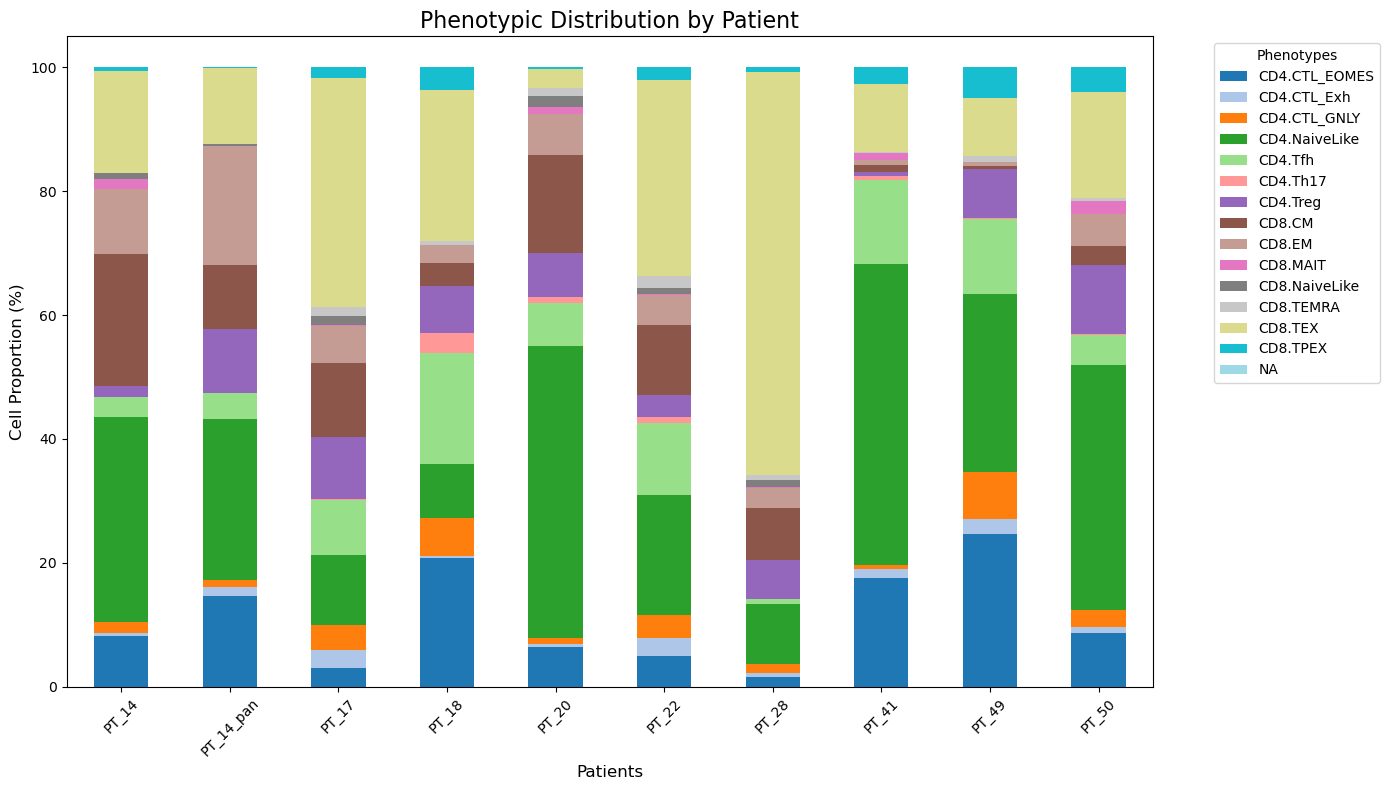

In [6]:
import mudata as mu
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo MuData
mdata_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/mudata_harmony_conTCR_KNN.h5mu"
mdata = mu.read(mdata_file)

# Access the data within the 'airr' module
airr_obs = mdata.mod['airr'].obs
gex_obs = mdata.mod['gex'].obs

# Verify that 'ATLAS_TIL_KNN' exists in 'gex.obs'
if 'ATLAS_TIL_KNN' not in gex_obs.columns:
    raise ValueError("The column 'ATLAS_TIL_KNN' is not in 'gex.obs'.")

# Copy the 'ATLAS_TIL_KNN' column from 'gex.obs' to 'airr.obs' ONLY if it does not exist
if 'ATLAS_TIL_KNN' not in airr_obs.columns:
    atlas_til_knn = gex_obs['ATLAS_TIL_KNN']
    insert_position = airr_obs.columns.get_loc('ATLAS_TIL_score') + 1
    airr_obs.insert(insert_position, 'ATLAS_TIL_KNN', atlas_til_knn.values)

# Verify that 'sample' exists in 'airr.obs'
if 'sample' not in airr_obs.columns:
    raise ValueError("The column 'sample' is not in 'airr.obs'. Check the data structure.")

# Extract the necessary data
df = airr_obs[['sample', 'ATLAS_TIL_KNN']].copy()

# Compute the percentage distribution of phenotypes per patient, including NA values
distribution = pd.crosstab(df['sample'], df['ATLAS_TIL_KNN'], normalize='index') * 100

# Handle NA values
na_counts = df['sample'].value_counts() - df.dropna(subset=['ATLAS_TIL_KNN'])['sample'].value_counts()
distribution['NA'] = (na_counts / df['sample'].value_counts()) * 100
distribution = distribution.fillna(0)  # Replace possible NaN values

# Normalize rows so each bar sums to 100%
distribution = distribution.div(distribution.sum(axis=1), axis=0) * 100

# Create the stacked bar plot WITHOUT small labels
fig, ax = plt.subplots(figsize=(14, 8))
bars = distribution.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Customize the plot
plt.title('Phenotypic Distribution by Patient', fontsize=16)
plt.xlabel('Patients', fontsize=12)
plt.ylabel('Cell Proportion (%)', fontsize=12)
plt.legend(title='Phenotypes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Acceder a los datos dentro del módulo 'airr'
airr_obs = mdata.mod['airr'].obs

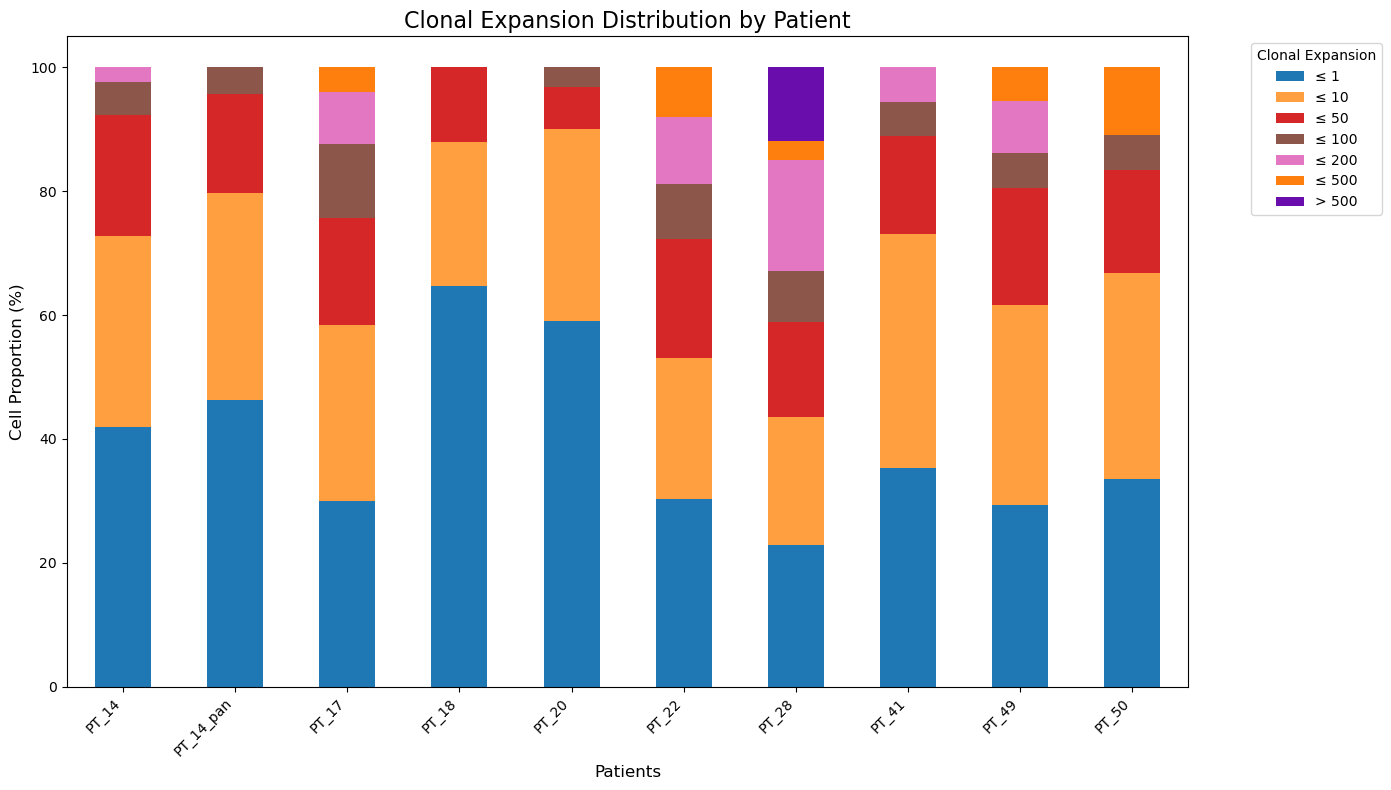

In [8]:
airr_obs = mdata.mod['airr'].obs

# Count the number of cells in each clonal expansion category per patient
clonal_distribution = pd.crosstab(airr_obs['sample'], airr_obs['clonal_expansion'], normalize='index') * 100

# Sort the columns in the correct order of categories
category_order = ['≤ 1', '≤ 10', '≤ 50', '≤ 100', '≤ 200', '≤ 500', '> 500']
clonal_distribution = clonal_distribution[category_order]

# Define custom colors with "> 500" in dark purple
custom_colors = {
    "≤ 1": "#1f77b4",   # Blue
    "≤ 10": "#ff9f40",  # Light orange
    "≤ 50": "#d62728",  # Dark red
    "≤ 100": "#8c564b", # Brown
    "≤ 200": "#e377c2", # Pink
    "≤ 500": "#ff7f0e", # Strong orange
    "> 500": "#6a0dad"  # Dark purple
}
colors = [custom_colors[cat] for cat in category_order]

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(14, 8))
clonal_distribution.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Customize the plot
plt.title('Clonal Expansion Distribution by Patient', fontsize=16)
plt.xlabel('Patients', fontsize=12)
plt.ylabel('Cell Proportion (%)', fontsize=12)
plt.legend(title='Clonal Expansion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

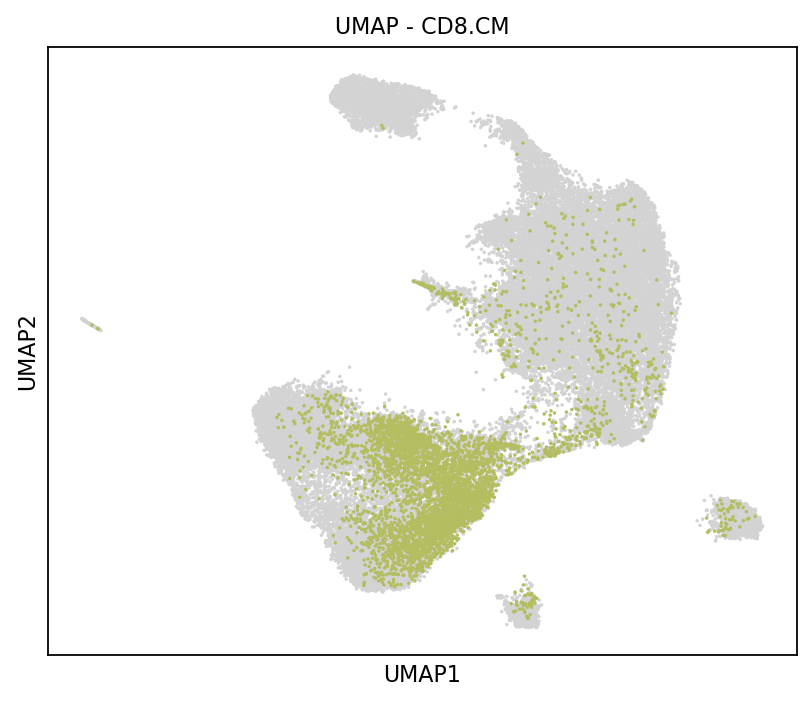

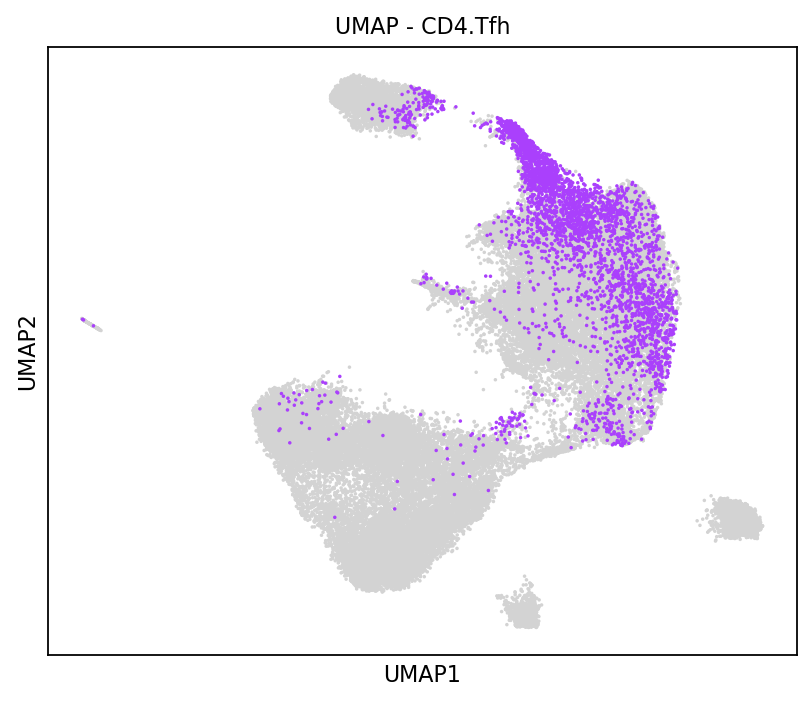

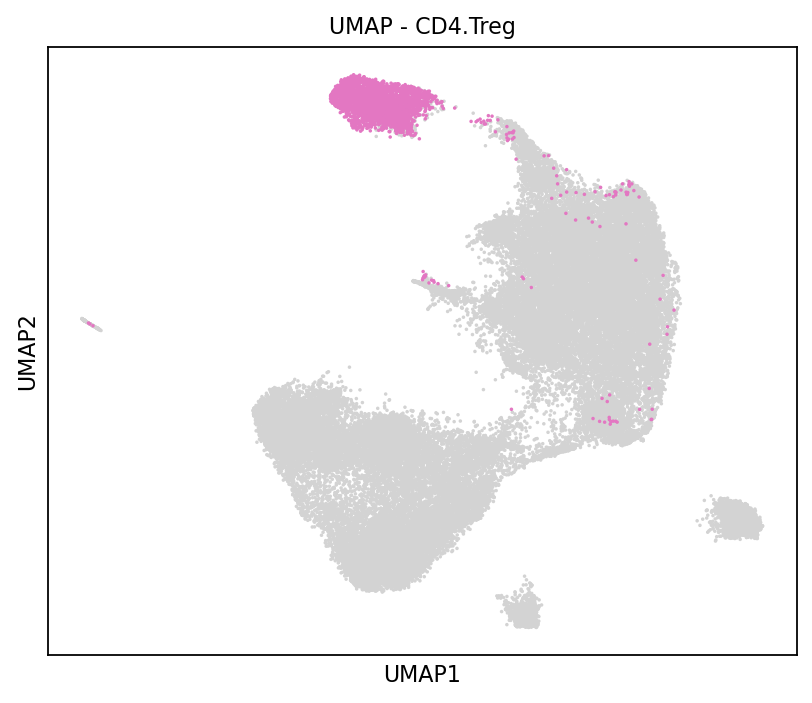

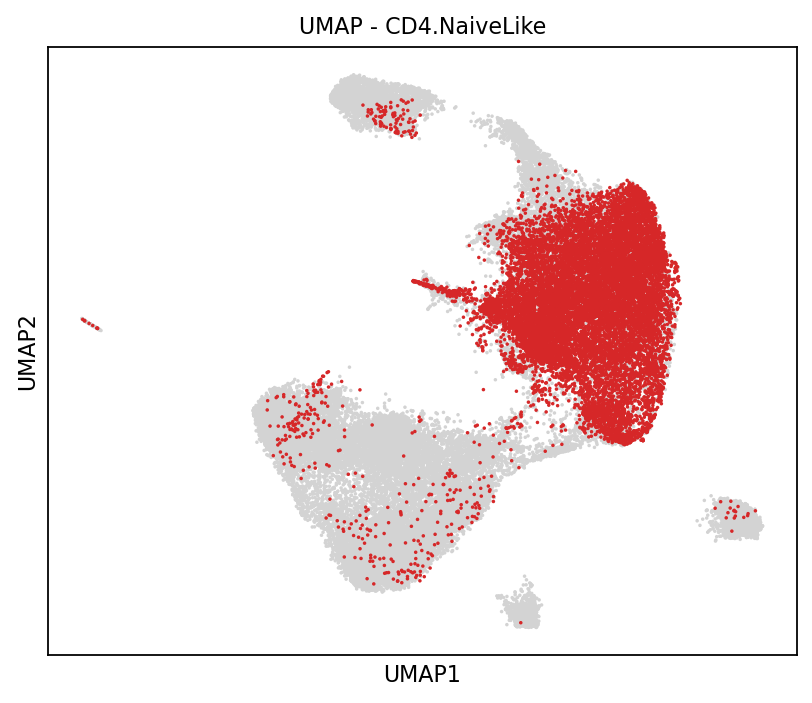

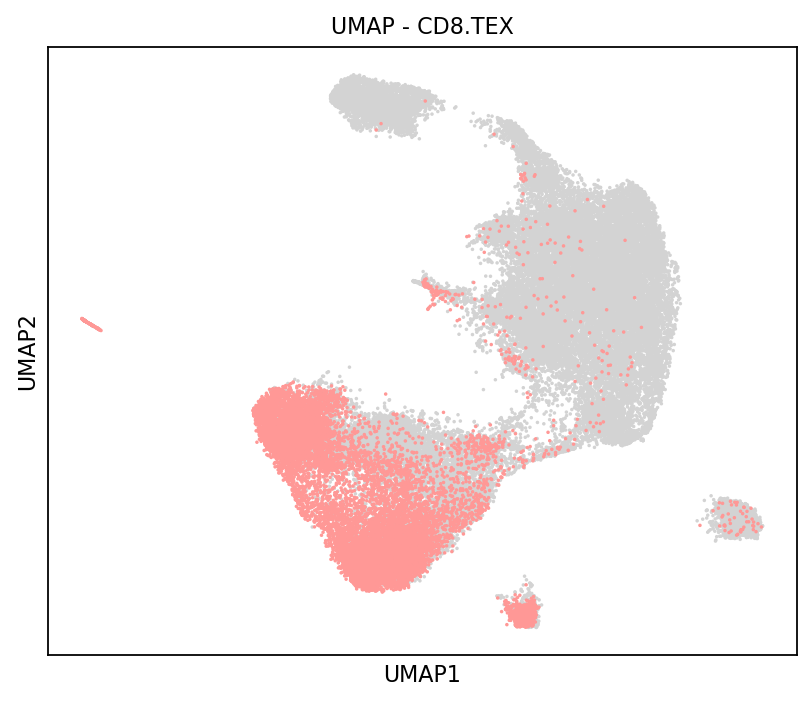

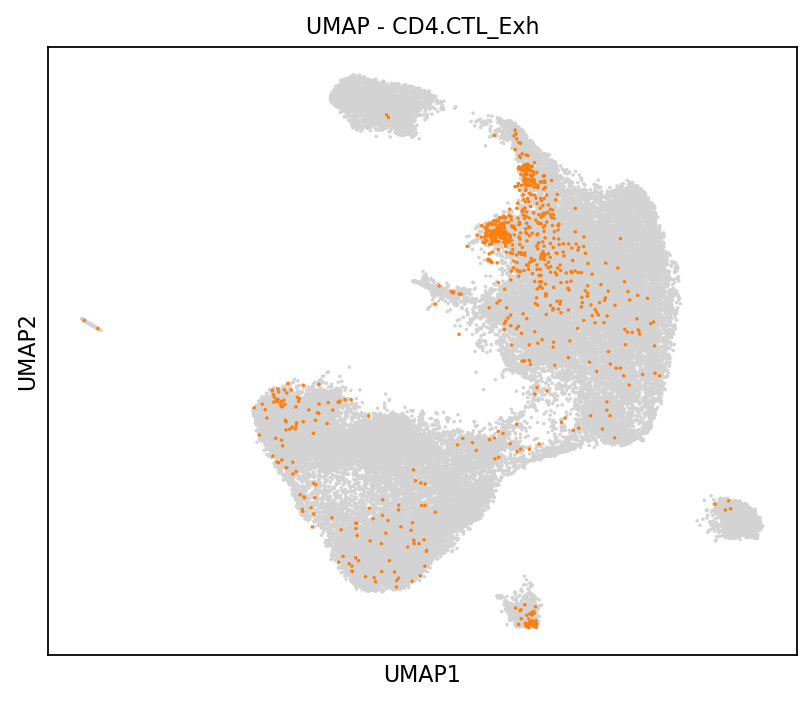

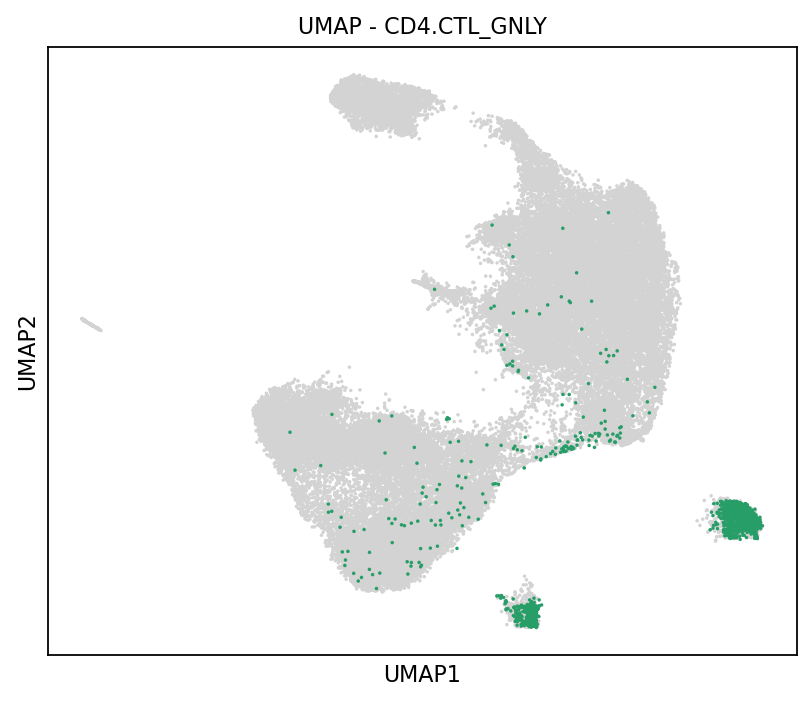

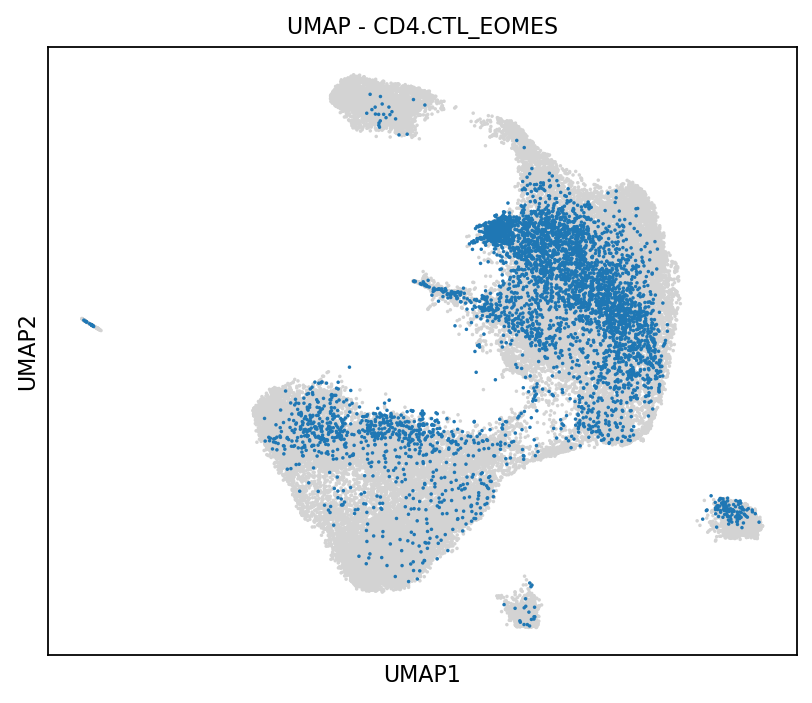

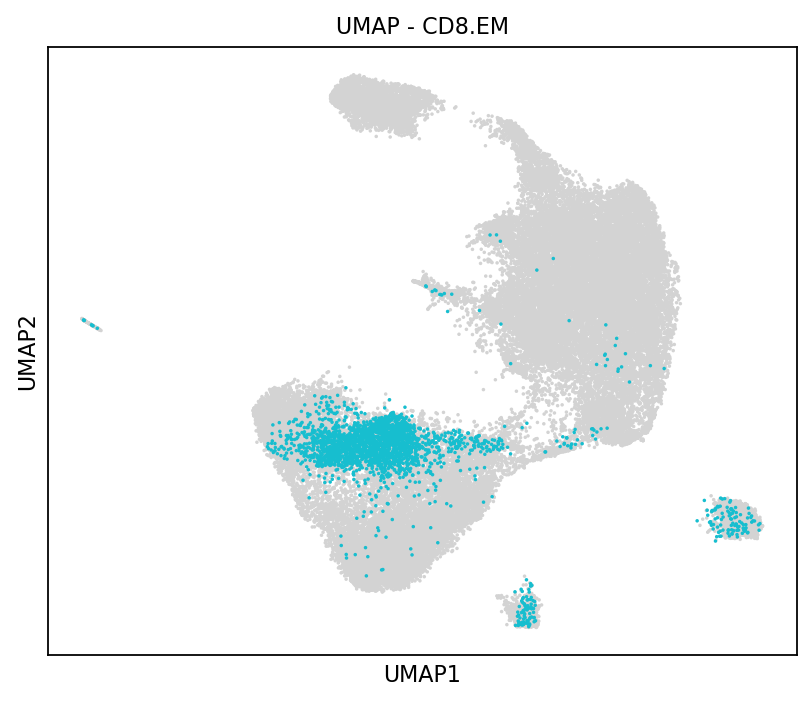

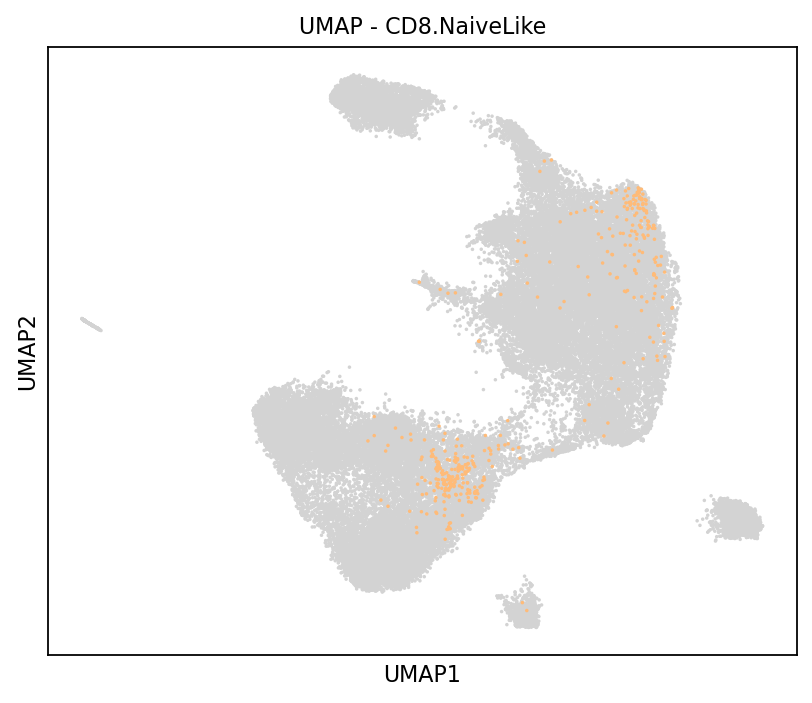

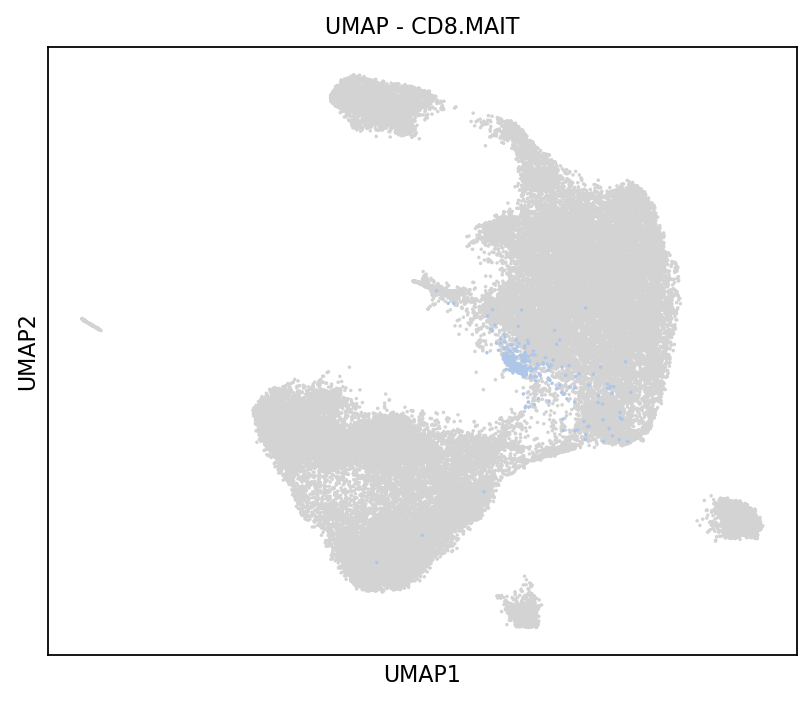

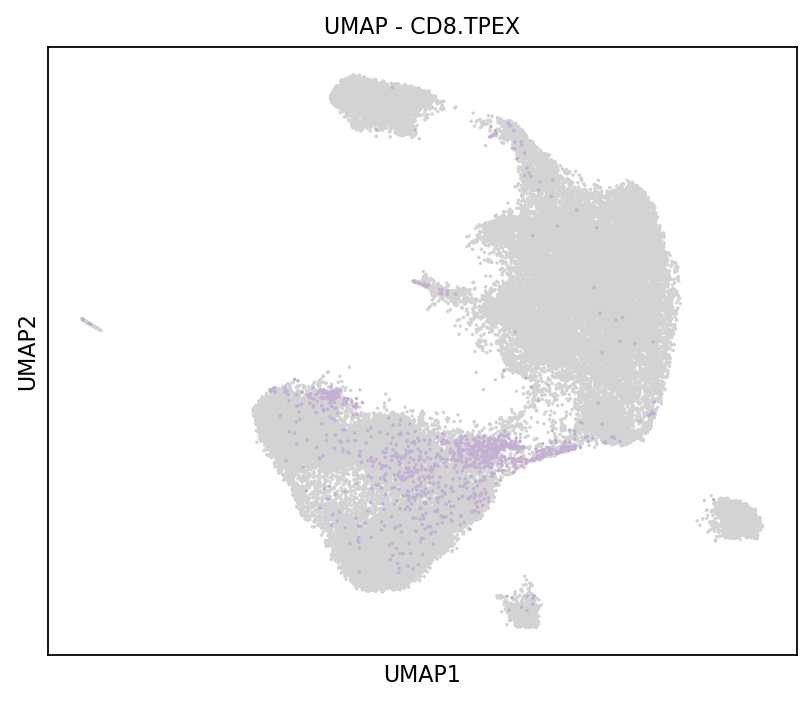

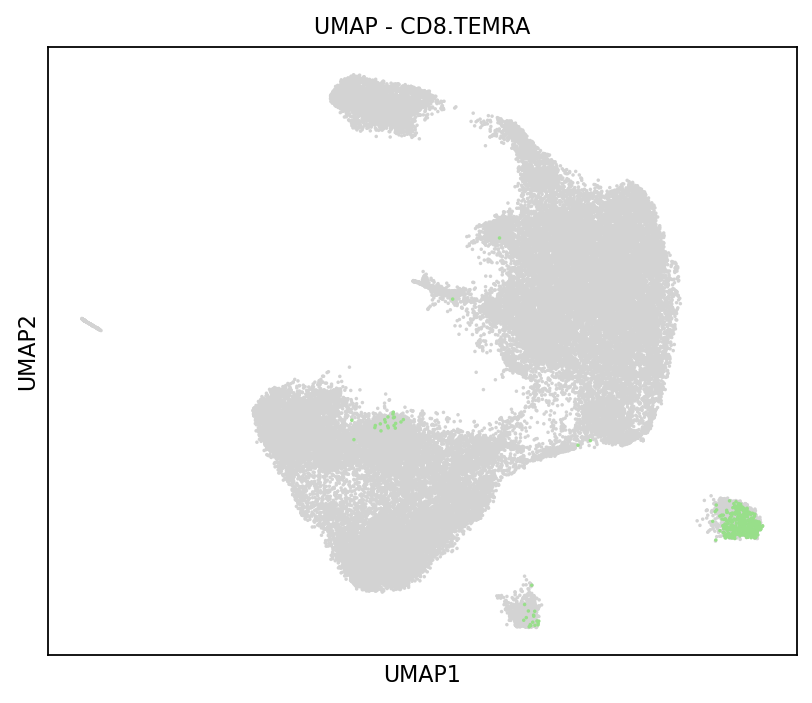

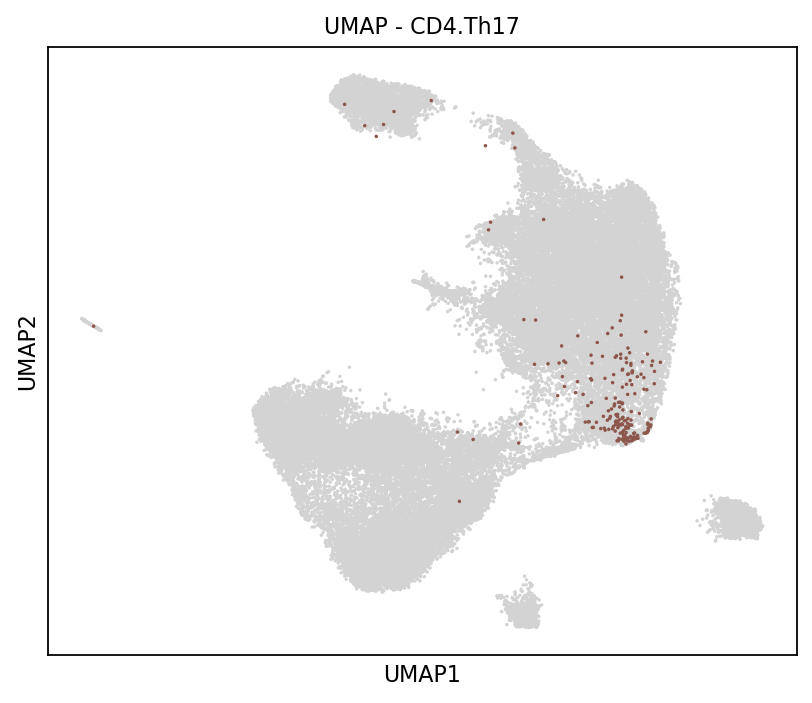

In [21]:
# Extraer el objeto AnnData correspondiente a 'gex' desde el MuData
adata_gex = mdata.mod['gex']

# Obtener los tipos de células únicos
cell_types = adata_gex.obs['ATLAS_TIL_KNN'].unique()

# Configurar los parámetros de la figura
sc.set_figure_params(figsize=(6, 5), fontsize=10)

# Generar un UMAP para cada tipo de célula por separado con los mismos colores de la última vez
for cell_type in cell_types:
    fig, ax = plt.subplots(figsize=(6, 5))  # Crear una figura nueva para cada UMAP
    
    sc.pl.umap(
        adata_gex,  # Graficamos todo el dataset
        color='ATLAS_TIL_KNN',
        groups=[cell_type],  # Resaltamos solo el grupo actual
        title=f'UMAP - {cell_type}',
        legend_loc='none',
        size=10,
        ax=ax,  # Dibujar en la figura actual
        show=True  # Mostrar inmediatamente cada imagen
    )


## Distancia jaccard  y TCRs compartidos

In [10]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL_KNN', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p', 'neighbors'
      obsm:	'X_pca_harmony', 'X_umap'
      layers:	'counts_soupx_crude', 'original_counts'
      obsp:	'connectivities', 'distances'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq', 'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ', 'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ', 'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score', 'ATLAS_TIL_KNN', 'Celltypist', 'Celltypist_score', 'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

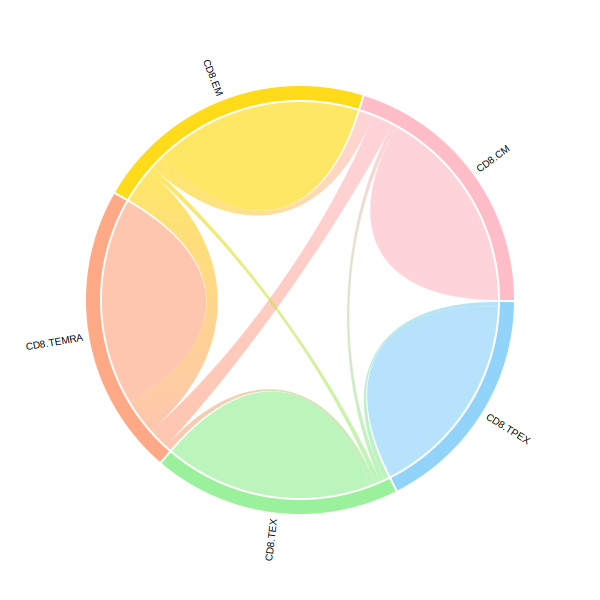

In [5]:
import mudata as mu
import pandas as pd
import numpy as np
import openchord as ocd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Acceder a la capa 'airr'
airr_data = mdata.mod['airr'].obs

# Filtrar solo los fenotipos de CD8 para el paciente PT_14
filtered_airr_data = airr_data[(airr_data['ATLAS_TIL_KNN'].str.contains("CD8")) & (airr_data['sample'] == "PT_18")]

# Extraer clústeres (fenotipos de CD8) y clones
clusters = sorted(filtered_airr_data['ATLAS_TIL_KNN'].unique())
clones = sorted(filtered_airr_data['clone_id'].unique())

# Crear matriz binaria de presencia/ausencia de clones en cada fenotipo
presence_matrix = pd.DataFrame(0, index=clusters, columns=clones)
for cluster in clusters:
    clones_in_cluster = filtered_airr_data[filtered_airr_data['ATLAS_TIL_KNN'] == cluster]['clone_id'].unique()
    presence_matrix.loc[cluster, clones_in_cluster] = 1

# Calcular matriz de similitud Jaccard (1 - distancia)
jaccard_distances = pdist(presence_matrix, metric='jaccard')
jaccard_matrix = 1 - squareform(jaccard_distances)
jaccard_df = pd.DataFrame(jaccard_matrix, index=clusters, columns=clusters)

# Crear matriz de adyacencia para OpenChord
adjacency_matrix = jaccard_df.to_numpy()

# Ajustar la visualización de los nombres
fig = ocd.Chord(adjacency_matrix, labels=clusters)

# **CORRECCIÓN PARA NOMBRES**
fig.figsize = (1500, 1500)  # Aumentamos el tamaño para que haya más espacio
fig.label_fontsize = 20      # Aumentamos el tamaño de los nombres
fig.label_font = "Arial Bold"  # Forzamos una fuente en negrita
fig.label_distance = 50      # Aumentamos la distancia de los nombres al círculo
fig.label_rotation = 0       # Forzamos la orientación recta de los nombres

# **Asegurar que los nombres no se salgan**
fig.padding = 100  # Agregar un espacio extra alrededor del gráfico

fig.show()



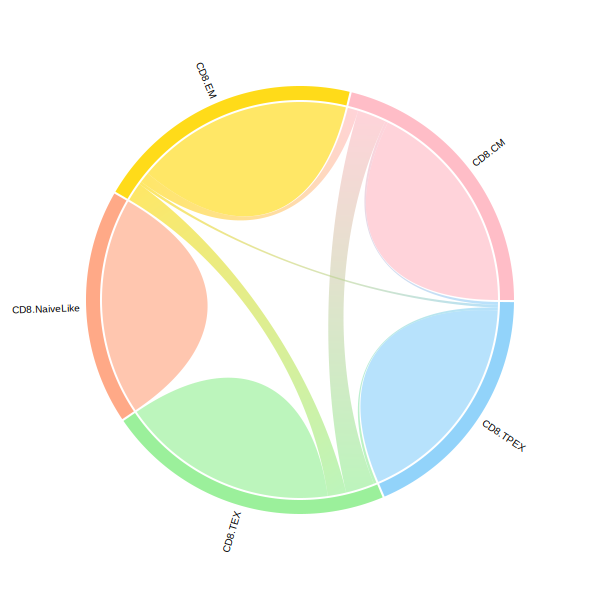

In [76]:
# Acceder a la capa 'airr'
airr_data = mdata.mod['airr'].obs

# Filtrar solo los fenotipos de CD8 para el paciente PT_14
filtered_airr_data = airr_data[(airr_data['ATLAS_TIL_KNN'].str.contains("CD8")) & (airr_data['sample'] == "PT_14_pan")]

# Extraer clústeres (fenotipos de CD8) y clones
clusters = sorted(filtered_airr_data['ATLAS_TIL_KNN'].unique())
clones = sorted(filtered_airr_data['clone_id'].unique())

# Crear matriz binaria de presencia/ausencia de clones en cada fenotipo
presence_matrix = pd.DataFrame(0, index=clusters, columns=clones)
for cluster in clusters:
    clones_in_cluster = filtered_airr_data[filtered_airr_data['ATLAS_TIL_KNN'] == cluster]['clone_id'].unique()
    presence_matrix.loc[cluster, clones_in_cluster] = 1

# Calcular matriz de similitud Jaccard (1 - distancia)
jaccard_distances = pdist(presence_matrix, metric='jaccard')
jaccard_matrix = 1 - squareform(jaccard_distances)
jaccard_df = pd.DataFrame(jaccard_matrix, index=clusters, columns=clusters)

# Crear matriz de adyacencia para OpenChord
adjacency_matrix = jaccard_df.to_numpy()

# Ajustar la visualización de los nombres
fig = ocd.Chord(adjacency_matrix, labels=clusters)

# **CORRECCIÓN PARA NOMBRES**
fig.figsize = (1500, 1500)  # Aumentamos el tamaño para que haya más espacio
fig.label_fontsize = 20      # Aumentamos el tamaño de los nombres
fig.label_font = "Arial Bold"  # Forzamos una fuente en negrita
fig.label_distance = 50      # Aumentamos la distancia de los nombres al círculo
fig.label_rotation = 0       # Forzamos la orientación recta de los nombres

# **Asegurar que los nombres no se salgan**
fig.padding = 100  # Agregar un espacio extra alrededor del gráfico

fig.show()


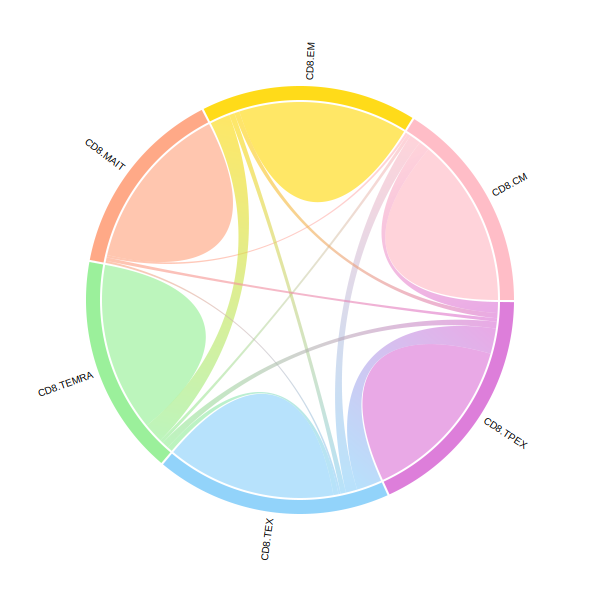

In [77]:
# Acceder a la capa 'airr'
airr_data = mdata.mod['airr'].obs

# Filtrar solo los fenotipos de CD8 para el paciente PT_14
filtered_airr_data = airr_data[(airr_data['ATLAS_TIL_KNN'].str.contains("CD8")) & (airr_data['sample'] == "PT_41")]

# Extraer clústeres (fenotipos de CD8) y clones
clusters = sorted(filtered_airr_data['ATLAS_TIL_KNN'].unique())
clones = sorted(filtered_airr_data['clone_id'].unique())

# Crear matriz binaria de presencia/ausencia de clones en cada fenotipo
presence_matrix = pd.DataFrame(0, index=clusters, columns=clones)
for cluster in clusters:
    clones_in_cluster = filtered_airr_data[filtered_airr_data['ATLAS_TIL_KNN'] == cluster]['clone_id'].unique()
    presence_matrix.loc[cluster, clones_in_cluster] = 1

# Calcular matriz de similitud Jaccard (1 - distancia)
jaccard_distances = pdist(presence_matrix, metric='jaccard')
jaccard_matrix = 1 - squareform(jaccard_distances)
jaccard_df = pd.DataFrame(jaccard_matrix, index=clusters, columns=clusters)

# Crear matriz de adyacencia para OpenChord
adjacency_matrix = jaccard_df.to_numpy()

# Ajustar la visualización de los nombres
fig = ocd.Chord(adjacency_matrix, labels=clusters)

# **CORRECCIÓN PARA NOMBRES**
fig.figsize = (1500, 1500)  # Aumentamos el tamaño para que haya más espacio
fig.label_fontsize = 16      # Aumentamos el tamaño de los nombres
fig.label_distance = 50      # Aumentamos la distancia de los nombres al círculo
fig.label_rotation = 0       # Forzamos la orientación recta de los nombres

# **Asegurar que los nombres no se salgan**
fig.padding = 100  # Agregar un espacio extra alrededor del gráfico

fig.show()



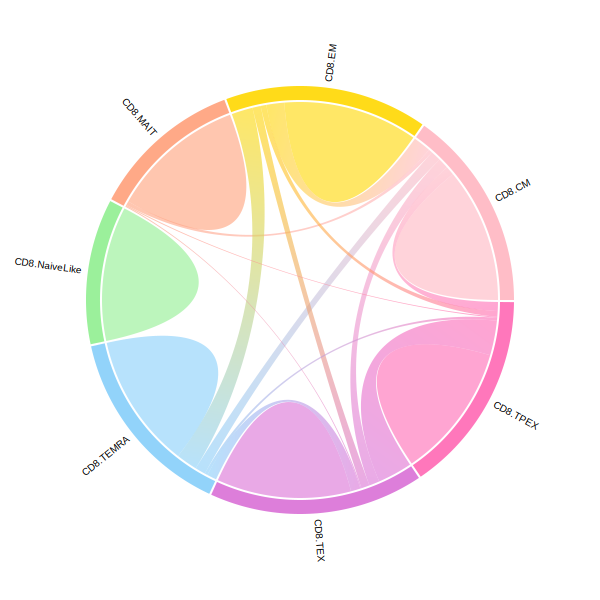

In [79]:
# Acceder a la capa 'airr'
airr_data = mdata.mod['airr'].obs

# Filtrar solo los fenotipos de CD8 para el paciente PT_14
filtered_airr_data = airr_data[(airr_data['ATLAS_TIL_KNN'].str.contains("CD8")) & (airr_data['sample'] == "PT_49")]

# Extraer clústeres (fenotipos de CD8) y clones
clusters = sorted(filtered_airr_data['ATLAS_TIL_KNN'].unique())
clones = sorted(filtered_airr_data['clone_id'].unique())

# Crear matriz binaria de presencia/ausencia de clones en cada fenotipo
presence_matrix = pd.DataFrame(0, index=clusters, columns=clones)
for cluster in clusters:
    clones_in_cluster = filtered_airr_data[filtered_airr_data['ATLAS_TIL_KNN'] == cluster]['clone_id'].unique()
    presence_matrix.loc[cluster, clones_in_cluster] = 1

# Calcular matriz de similitud Jaccard (1 - distancia)
jaccard_distances = pdist(presence_matrix, metric='jaccard')
jaccard_matrix = 1 - squareform(jaccard_distances)
jaccard_df = pd.DataFrame(jaccard_matrix, index=clusters, columns=clusters)

# Crear matriz de adyacencia para OpenChord
adjacency_matrix = jaccard_df.to_numpy()

# Ajustar la visualización de los nombres
fig = ocd.Chord(adjacency_matrix, labels=clusters)

# **CORRECCIÓN PARA NOMBRES**
fig.figsize = (1500, 1500)  # Aumentamos el tamaño para que haya más espacio
fig.label_fontsize = 16      # Aumentamos el tamaño de los nombres
fig.label_distance = 50      # Aumentamos la distancia de los nombres al círculo
fig.label_rotation = 0       # Forzamos la orientación recta de los nombres

# **Asegurar que los nombres no se salgan**
fig.padding = 100  # Agregar un espacio extra alrededor del gráfico

fig.show()

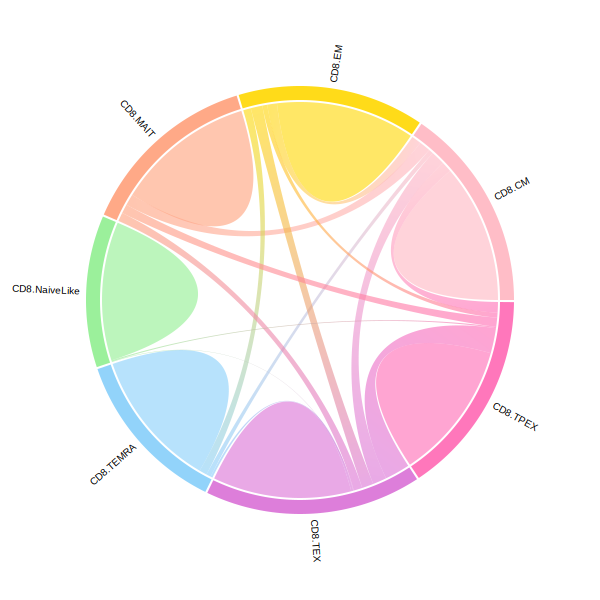

In [80]:
# Acceder a la capa 'airr'
airr_data = mdata.mod['airr'].obs

# Filtrar solo los fenotipos de CD8 para el paciente PT_14
filtered_airr_data = airr_data[(airr_data['ATLAS_TIL_KNN'].str.contains("CD8")) & (airr_data['sample'] == "PT_50")]

# Extraer clústeres (fenotipos de CD8) y clones
clusters = sorted(filtered_airr_data['ATLAS_TIL_KNN'].unique())
clones = sorted(filtered_airr_data['clone_id'].unique())

# Crear matriz binaria de presencia/ausencia de clones en cada fenotipo
presence_matrix = pd.DataFrame(0, index=clusters, columns=clones)
for cluster in clusters:
    clones_in_cluster = filtered_airr_data[filtered_airr_data['ATLAS_TIL_KNN'] == cluster]['clone_id'].unique()
    presence_matrix.loc[cluster, clones_in_cluster] = 1

# Calcular matriz de similitud Jaccard (1 - distancia)
jaccard_distances = pdist(presence_matrix, metric='jaccard')
jaccard_matrix = 1 - squareform(jaccard_distances)
jaccard_df = pd.DataFrame(jaccard_matrix, index=clusters, columns=clusters)

# Crear matriz de adyacencia para OpenChord
adjacency_matrix = jaccard_df.to_numpy()

# Ajustar la visualización de los nombres
fig = ocd.Chord(adjacency_matrix, labels=clusters)

# **CORRECCIÓN PARA NOMBRES**
fig.figsize = (1500, 1500)  # Aumentamos el tamaño para que haya más espacio
fig.label_fontsize = 16      # Aumentamos el tamaño de los nombres
fig.label_distance = 50      # Aumentamos la distancia de los nombres al círculo
fig.label_rotation = 0       # Forzamos la orientación recta de los nombres

# **Asegurar que los nombres no se salgan**
fig.padding = 100  # Agregar un espacio extra alrededor del gráfico

fig.show()